In [7]:
import sys
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../data')

import torch
import plotly.express as px
import src.nanda_plot

from src.model import WrapHookedTransformer

from src.nanda_plot import imshow_reversed, imshow
import pandas as pd
from tqdm import tqdm
import numpy as np


%load_ext autoreload
%autoreload 2

In [8]:
model = WrapHookedTransformer.from_pretrained("gpt2", device="cuda", refactor_factored_attn_matrices=True)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [9]:
import json
data = json.load(open("../data/counterfact.json"))
my_data = []
for i,d in tqdm(enumerate(data), total=len(data)):
    target_new = " " + d["requested_rewrite"]["target_true"]["str"]
    target_true = " " + d["requested_rewrite"]["target_new"]["str"]
    if i % 50 == 0:
        unique_strs = set(json.dumps(d) for d in my_data)
        my_data = [json.loads(s) for s in unique_strs]
        print(len(my_data))
        # if len(my_data) > 1000:
        #     break
    for p in d["attribute_prompts"]:
        template = "Redefine: " + p + "{}" + ". " + p
        #find position of {} in template
        if len(model.to_str_tokens(template.format(model.tokenizer.pad_token))) not in [17]:
            continue
        try:
            obj_pos = model.to_str_tokens(template.format(model.tokenizer.pad_token)).index(".") - 1
        except:
            continue
        if target_true in template:
            continue
        position = template.find("{}")
        prediction = model.predict(template.format(model.tokenizer.pad_token))[1][0]
        copy_prediction = model.predict(template.format(target_new))[1][0]
        if prediction == target_true and copy_prediction == target_new:
            my_data.append({
                "prompt": p,
                "template": template,
                "prediction": prediction,
                "copy_prediction": copy_prediction,
                "target_true": target_true,
                "target_new": target_new,
                "length": len(model.to_str_tokens(template.format(model.tokenizer.pad_token))),
                "lenght_copy": len(model.to_str_tokens(template.format(target_new))),
                "obj_pos": obj_pos,
               
            })
    for p in d["neighborhood_prompts"]:
        template = "Redefine: " + p + "{}" + ". " + p
        #find position of {} in template
        if len(model.to_str_tokens(template.format(model.tokenizer.pad_token))) not in [17]:
            continue
        try:
            obj_pos = model.to_str_tokens(template.format(model.tokenizer.pad_token)).index(".") - 1
        except:
            continue
        if target_true in template:
            continue
        position = template.find("{}")
        prediction = model.predict(template.format(model.tokenizer.pad_token))[1][0]
        copy_prediction = model.predict(template.format(target_new))[1][0]
        if prediction == target_true and copy_prediction == target_new:
            # check if is a duplicate
            
            my_data.append({
                "prompt": p,
                "template": template,
                "prediction": prediction,
                "copy_prediction": copy_prediction,
                "target_true": target_new,
                "target_new": target_true,
                "length": len(model.to_str_tokens(template.format(model.tokenizer.pad_token))),
                "lenght_copy": len(model.to_str_tokens(template.format(target_new))),
                "obj_pos": obj_pos,
               
            })

# check for duplicates
import pandas as pd
df = pd.DataFrame(my_data)
# print number of duplicates
print("Number of duplicates: ", len(df) - len(df.drop_duplicates()))
        

# json.dump(my_data, open("../data/counterfact_small.json", "w"), indent=2)    

  0%|          | 0/21919 [00:00<?, ?it/s]

0


  0%|          | 55/21919 [00:02<12:10, 29.93it/s] 

5


  0%|          | 60/21919 [00:03<18:54, 19.26it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:53                                                                                   │
│                                                                                                  │
│   50 │   │   │   continue                                                                        │
│   51 │   │   position = template.find("{}")                                                      │
│   52 │   │   prediction = model.predict(template.format(model.tokenizer.pad_token))[1][0]        │
│ ❱ 53 │   │   copy_prediction = model.predict(template.format(target_new))[1][0]                  │
│   54 │   │   if prediction == target_true and copy_prediction == target_new:                     │
│   55 │   │   │   # check if is a duplicate                                                       │
│   56                                                                                             │
│                                                                                                  │
│ /home/francesco/Repository/Competition_of_Mechanisms/notebooks/../src/model.py:19 in predict     │
│                                                                                                  │
│    16 │   │   super().__init__(*args, **kwargs)                                                  │
│    17 │   │   self.device = self.cfg.device                                                      │
│    18 │   def predict(self, prompt: str, k: int = 1, return_type: str = "logits"):               │
│ ❱  19 │   │   logits = self(prompt)                                                              │
│    20 │   │   return get_predictions(self, logits, k, return_type)                               │
│    21                                                                                            │
│    22                                                                                            │
│                                                                                                  │
│ /home/francesco/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/francesco/anaconda3/envs/torch/lib/python3.10/site-packages/transformer_lens/HookedTransfo │
│ rmer.py:480 in forward                                                                           │
│                                                                                                  │
│    477 │   │   │   │   │   │   devices.get_device_for_block_index(i, self.cfg)                   │
│    478 │   │   │   │   │   )                                                                     │
│    479 │   │   │   │                                                                             │
│ ❱  480 │   │   │   │   residual = block(                                                         │
│    481 │   │   │   │   │   residual,                       

In [10]:
import json
my_data = json.load(open("../data/counterfact_small_15_final.json"))
print(len(my_data))
# sample random 50 examples
# import random
# random.seed(129)
# random.shuffle(my_data)
# my_data = my_data[:1000]
print(len(my_data))

1519
1519


In [11]:
# json.dump(my_data, open("../data/counterfact_small_15_final.json", "w"), indent=2)

In [4]:
#print number for length of templates
print("Number of templates with length 19: ", len([d for d in my_data if d["length"] == 17]))



Number of templates with length 19:  378


In [11]:
my_data = [d for d in my_data if d["length"] == 17]

## Patch

In [12]:
from torch.utils.data import DataLoader, Dataset

class CounterfactDataset(Dataset):
    def __init__(self, data):
        pad_token = model.tokenizer.pad_token
        self.clean_prompts = [d["template"].format(pad_token) for d in data]
        self.corrupted_prompts = [d["template"].format(d["target_new"]) for d in data]

        target1 = [model.to_tokens(d["target_true"], prepend_bos=False) for d in data]
        target2 = [model.to_tokens(d["target_new"], prepend_bos=False) for d in data]
        tensor_1 = torch.stack(target1, dim=0)
        tensor_2 = torch.stack(target2, dim=0)
        # stack the tensors
        self.target = torch.stack([tensor_1, tensor_2], dim=1).squeeze()
    def __len__(self):
        return len(self.clean_prompts)
    def __getitem__(self, idx):
        return {
            "clean_prompts": self.clean_prompts[idx],
            "corrupted_prompts": self.corrupted_prompts[idx],
            "target": self.target[idx]
        }
    def filter_from_idx(self, index, exclude=False):
        if exclude:
            self.target = [self.target[i] for i in range(len(self.target)) if i not in index]
            self.clean_prompts = [self.clean_prompts[i] for i in range(len(self.clean_prompts)) if i not in index]
        
            self.corrupted_prompts = [self.corrupted_prompts[i] for i in range(len(self.corrupted_prompts)) if i not in index]
        else:
            self.target = [self.target[i] for i in index][:200]
            self.clean_prompts = [self.clean_prompts[i] for i in index][:200]
            self.corrupted_prompts = [self.corrupted_prompts[i] for i in index][:200]
    
    def slice(self, end, start=0):
        self.target = self.target[start:end]
        self.clean_prompts = self.clean_prompts[start:end]
        self.corrupted_prompts = self.corrupted_prompts[start:end]
    
        
        
dataset = CounterfactDataset(my_data)
batch_size=40
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
num_batches = len(dataloader)
torch.set_grad_enabled(False)

clean_logits = []
corrupted_logits = []
target = []
for batch in tqdm(dataloader, total=num_batches):
    clean_logits.append(model(batch["clean_prompts"])[:,-1,:].cpu())
    corrupted_logits.append(model(batch["corrupted_prompts"])[:,-1,:].cpu())
    target.append(batch["target"].cpu())
clean_logit = torch.cat(clean_logits, dim=0)
corrupted_logit = torch.cat(corrupted_logits, dim=0)
target = torch.cat(target, dim=0)

100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


In [13]:
def to_logit_token(logit, target):
    logit = torch.log_softmax(logit, dim=-1)
    logit_mem = torch.zeros(target.shape[0])
    logit_cp = torch.zeros(target.shape[0])
    for i in range(target.shape[0]):
        logit_mem[i] = logit[i, target[i,0]]
        logit_cp[i] = logit[i, target[i,1]]
    return logit_mem, logit_cp

CLEAN_LOGIT_MEM = to_logit_token(clean_logit, target)[0]
CLEAN_LOGIT_CP = to_logit_token(clean_logit, target)[1]
CORRUPTED_LOGIT_MEM = to_logit_token(corrupted_logit, target)[0]
CORRUPTED_LOGIT_CP = to_logit_token(corrupted_logit, target)[1]

def normalize_logit_token(logit, target):
    logit_mem, logit_cp = to_logit_token(logit, target)
    # percentage increase or decrease of logit_mem
    logit_mem = 100 * (logit_mem - CLEAN_LOGIT_MEM) / CLEAN_LOGIT_MEM
    # percentage increase or decrease of logit_cp
    logit_cp = 100 * (logit_cp - CLEAN_LOGIT_CP) / CLEAN_LOGIT_CP
    return logit_mem, logit_cp

# get the index of the outliers
outliers_under = torch.where(CORRUPTED_LOGIT_MEM < (CORRUPTED_LOGIT_MEM.mean() - CORRUPTED_LOGIT_MEM.std()) )[0]
outliers_over = torch.where(CORRUPTED_LOGIT_MEM > (CORRUPTED_LOGIT_MEM.mean() + CORRUPTED_LOGIT_MEM.std()) )[0]
outliers_indexes = torch.cat([outliers_under, outliers_over], dim=0).tolist()
both_high = torch.where((CORRUPTED_LOGIT_MEM > (CORRUPTED_LOGIT_MEM.mean() + CORRUPTED_LOGIT_MEM.std())) & (CLEAN_LOGIT_CP > (CLEAN_LOGIT_CP.mean() + CLEAN_LOGIT_CP.std())))[0]

print("Both high: ", len(both_high), len(list(set(both_high.tolist()).intersection(set(outliers_indexes)))))
print("Outliers found: ", 100 * len(outliers_indexes)/len(my_data), "%")

maxdatasize = ((len(my_data) - len(outliers_indexes)) // batch_size) * batch_size

dataset.filter_from_idx(outliers_indexes, exclude=True)
dataset.slice(maxdatasize)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
num_batches = len(dataloader)
torch.set_grad_enabled(False)
print("dataset len:",len(dataset))

clean_logits = []
corrupted_logits = []
target = []
for batch in tqdm(dataloader, total=num_batches):
    clean_logits.append(model(batch["clean_prompts"])[:,-1,:].cpu())
    corrupted_logits.append(model(batch["corrupted_prompts"])[:,-1,:].cpu())
    target.append(batch["target"].cpu())
clean_logit = torch.cat(clean_logits, dim=0)
corrupted_logit = torch.cat(corrupted_logits, dim=0)
target = torch.cat(target, dim=0)

Both high:  8 8
Outliers found:  23.280423280423282 %
dataset len: 280


100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


In [28]:
def to_logit_token(logit, target):
    logit = torch.log_softmax(logit, dim=-1)
    logit_mem = torch.zeros(target.shape[0])
    logit_cp = torch.zeros(target.shape[0])
    for i in range(target.shape[0]):
        logit_mem[i] = logit[i, target[i,0]] 
        logit_cp[i] = logit[i, target[i,1]]
    return logit_mem, logit_cp

CLEAN_LOGIT_MEM = to_logit_token(clean_logit, target)[0]
CLEAN_LOGIT_CP = to_logit_token(clean_logit, target)[1]
CORRUPTED_LOGIT_MEM = to_logit_token(corrupted_logit, target)[0]
CORRUPTED_LOGIT_CP = to_logit_token(corrupted_logit, target)[1]

def normalize_logit_token(logit_mem, logit_cp,  baseline="corrupted",):
    # logit_mem, logit_cp = to_logit_token(logit, target)
    # percentage increase or decrease of logit_mem
    if baseline == "clean":
        logit_mem = 100 * (logit_mem - CLEAN_LOGIT_MEM) / CLEAN_LOGIT_MEM
        # percentage increase or decrease of logit_cp
        logit_cp = 100 * (logit_cp - CLEAN_LOGIT_CP) / CLEAN_LOGIT_CP
        return -logit_mem, -logit_cp
    elif baseline == "corrupted":
        logit_mem = 100 * (logit_mem - CORRUPTED_LOGIT_MEM) / CORRUPTED_LOGIT_MEM
        # percentage increase or decrease of logit_cp
        logit_cp = 100 * (logit_cp - CORRUPTED_LOGIT_CP) / CORRUPTED_LOGIT_CP
        return -logit_mem, -logit_cp

In [17]:
# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmaps(result, result_std, title, interval, save=False):
    sns.set()
    sns.set_style("whitegrid", {"axes.grid": False})
    # add also the std heatmap
    fig, ax = plt.subplots(1, 2, figsize=(22, 8))
    ax[0].set_title("Average logit difference")
    ax[1].set_title("Std logit difference")
    # make the center of the heatmap 0 and white color
    sns.heatmap(
        result.detach().cpu().numpy(),
        annot=True,
        fmt=".2f",
        cbar=False,
        ax=ax[0],
        center=1.0,
        vmax=interval,
        vmin=-interval,
        cmap="RdBu_r",
    )
    # label the axes
    ax[0].set_xlabel("Head")
    ax[0].set_ylabel("Layer")
    sns.heatmap(
        result_std.detach().cpu().numpy(),
        annot=True,
        fmt=".2f",
        cbar=False,
        ax=ax[1],
        center=0.0,
        vmax=interval,
        vmin=-interval,
        cmap="RdBu_r",
    )





In [10]:
# patch attention head
from functools import partial
from tqdm import tqdm
import einops
from copy import deepcopy


def heads_hook(activation, hook, head,  pos1=None, pos2=None):
    activation[:, head, -1, :] = 0
    return activation

def freeze_hook(activation, hook,  clean_activation, pos1=None, pos2=None):
    activation = clean_activation
    return activation


examples_mem = torch.zeros((model.cfg.n_layers, model.cfg.n_heads, num_batches, batch_size), device="cpu")
examples_cp = torch.zeros((model.cfg.n_layers, model.cfg.n_heads, num_batches, batch_size), device="cpu")


for idx, batch in enumerate(dataloader):
    corrupted_logit, corrupted_cache = model.run_with_cache(batch["clean_prompts"])
    clean_logit, clean_cache = model.run_with_cache(batch["corrupted_prompts"])
    hooks = {}
    for layer in tqdm(range(model.cfg.n_layers), desc="setting hooks"):
        # for head in range(model.cfg.n_heads):
        hooks[f"L{layer}"] = (f"blocks.{layer}.hook_attn_out",
                        partial(
                            freeze_hook,
                            clean_activation=clean_cache[f"blocks.{layer}.hook_attn_out"],
                            )
                        )
            
    for layer in tqdm(range(model.cfg.n_layers), desc="running model"):
        for head in range(model.cfg.n_heads):
            tmp_hooks = deepcopy(hooks)
            tmp_hooks[f"L{layer}"] = (f"blocks.{layer}.attn.hook_pattern",
                            partial(
                                heads_hook,
                                head=head,
                                )
                            )
            
            list_hooks = list(tmp_hooks.values())
            model.reset_hooks()
            logit = model.run_with_hooks(
                batch["corrupted_prompts"],
                fwd_hooks=list_hooks,
            )[:,-1,:]
            mem, cp = to_logit_token(logit, batch["target"])
            # norm_mem, norm_cp = normalize_logit_token(mem, cp, baseline="corrupted")
            examples_mem[layer, head, idx, :] = mem.cpu()
            examples_cp[layer, head, idx, :] = cp.cpu()
        #remove the hooks for the previous layer

        hooks.pop(f"L{layer}")
        
examples_mem = einops.rearrange(examples_mem, "l h b s -> l h (b s)")
examples_cp = einops.rearrange(examples_cp, "l h b s -> l h (b s)")
for layer in range(model.cfg.n_layers):
    for head in range(model.cfg.n_heads):
        norm_mem, norm_cp = normalize_logit_token(examples_mem[layer, head, :], examples_cp[layer, head, :], baseline="corrupted")
        examples_mem[layer, head, :] = norm_mem
        examples_cp[layer, head, :] = norm_cp
result_cp = examples_cp.mean(dim=-1)
result_cp_std = examples_cp.std(dim=-1)
result_mem = examples_mem.mean(dim=-1)
result_mem_std = examples_mem.std(dim=-1)

plot_heatmaps(result_cp, result_cp_std)
plot_heatmaps(result_mem, result_mem_std)


running model: 100%|██████████| 12/12 [00:17<00:00,  1.45s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:70                                                                                   │
│                                                                                                  │
│   67 result_mem = examples_mem.mean(dim=-1)                                                      │
│   68 result_mem_std = examples_mem.std(dim=-1)                                                   │
│   69                                                                                             │
│ ❱ 70 plot_heatmaps(result_cp, result_cp_std)                                                     │
│   71 plot_heatmaps(result_mem, result_mem_std)                                                   │
│   72                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: plot_heatmaps() missing 2 required positional arguments: 'title' and 'interval'

In [11]:
def save_result(result_cp, result_mem, filename):
    path = f"../results/circuit_discovery/{filename}"
    torch.save(result_cp, path + "_cp.pt")
    torch.save(result_mem, path + "_mem.pt")
    
# save_result(examples_cp, examples_mem, "clean->corrupted_17")
# examples_cp = torch.load("../results/circuit_discovery/clean->corrupted_full_cp.pt")
# examples_mem = torch.load("../results/circuit_discovery/clean->corrupted_full_mem.pt")

In [13]:
example_cp_17 = torch.load("../results/circuit_discovery/clean->corrupted_17_cp.pt")
example_mem_17 = torch.load("../results/circuit_discovery/clean->corrupted_17_mem.pt")
example_cp_19 = torch.load("../results/circuit_discovery/clean->corrupted_19_cp.pt")
example_mem_19 = torch.load("../results/circuit_discovery/clean->corrupted_19_mem.pt")
example_cp_21 = torch.load("../results/circuit_discovery/clean->corrupted_21_cp.pt")
example_mem_21 = torch.load("../results/circuit_discovery/clean->corrupted_21_mem.pt")
example_cp = torch.cat([example_cp_17, example_cp_19, example_cp_21], dim=-1)
example_mem = torch.cat([example_mem_17 ,example_mem_19, example_mem_21], dim=-1)
print(example_cp.shape)

torch.Size([12, 12, 1080])


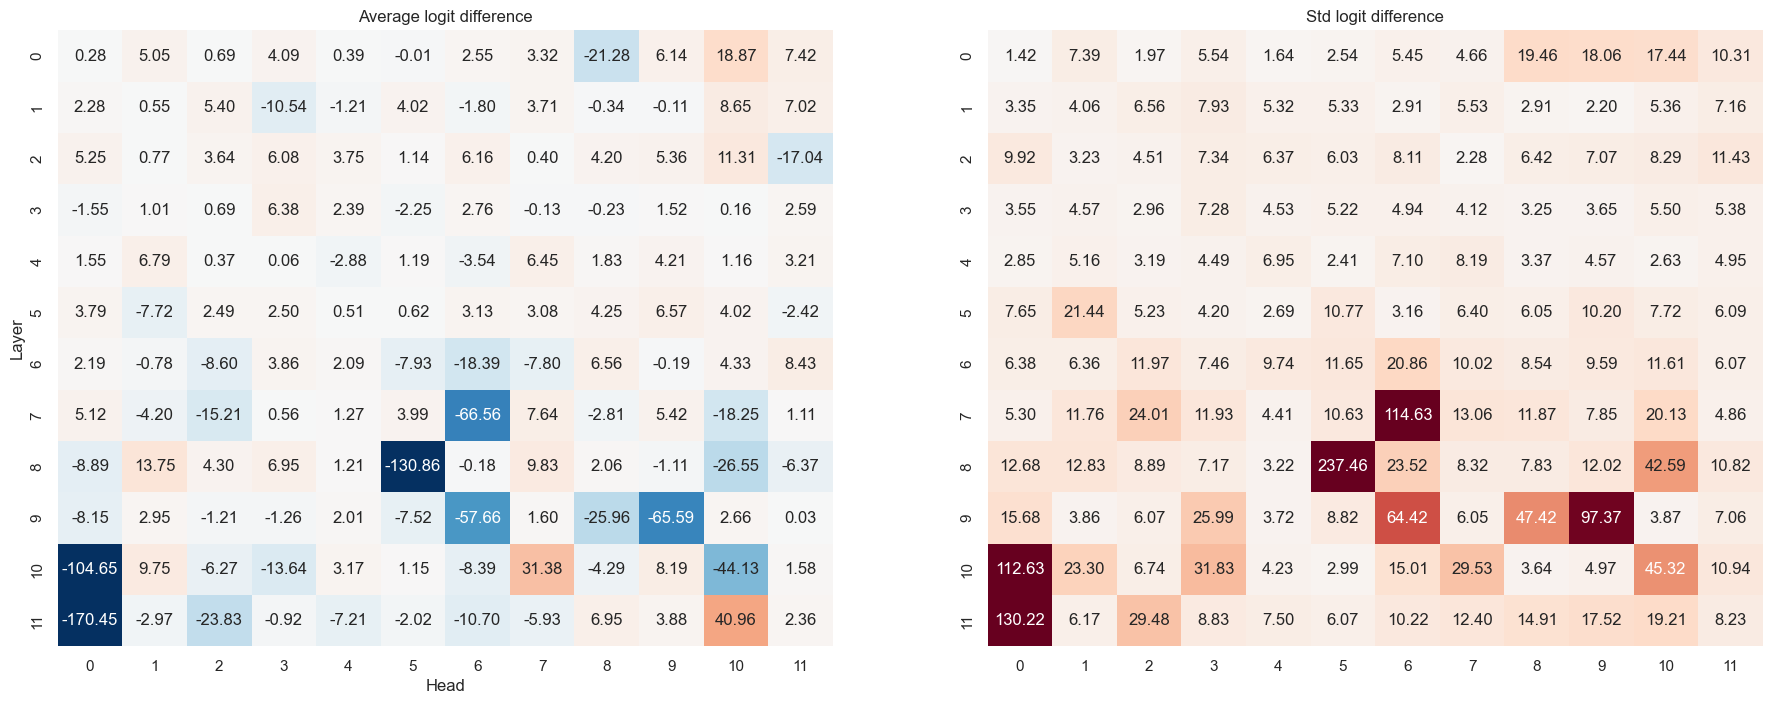

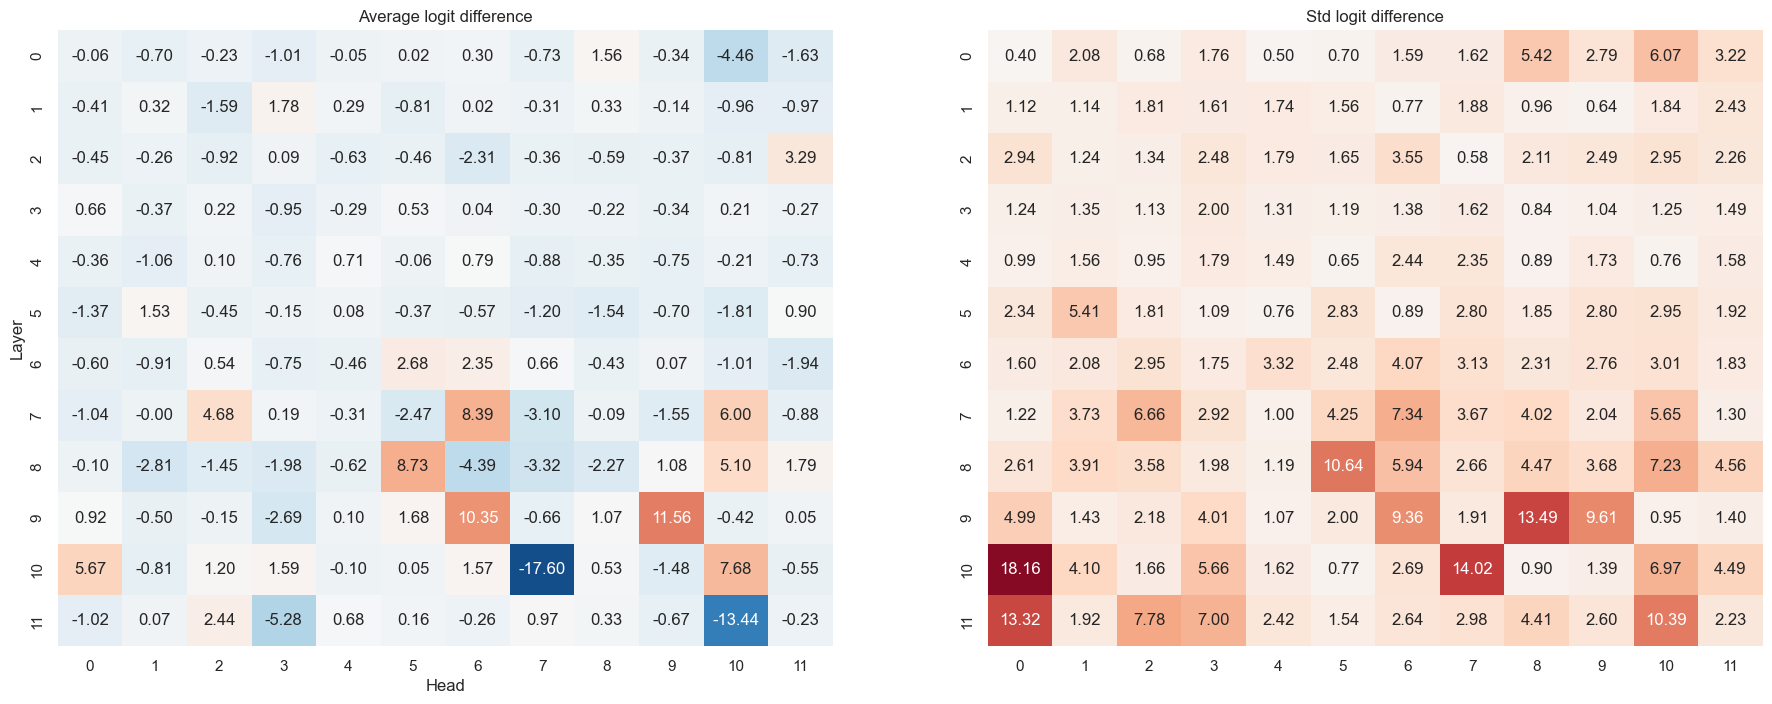

In [14]:
plot_heatmaps(example_cp.mean(-1), example_cp.std(-1), title="CP", interval = 100)
plot_heatmaps(example_mem.mean(-1), example_mem.std(-1), title="MEM", interval = 20)

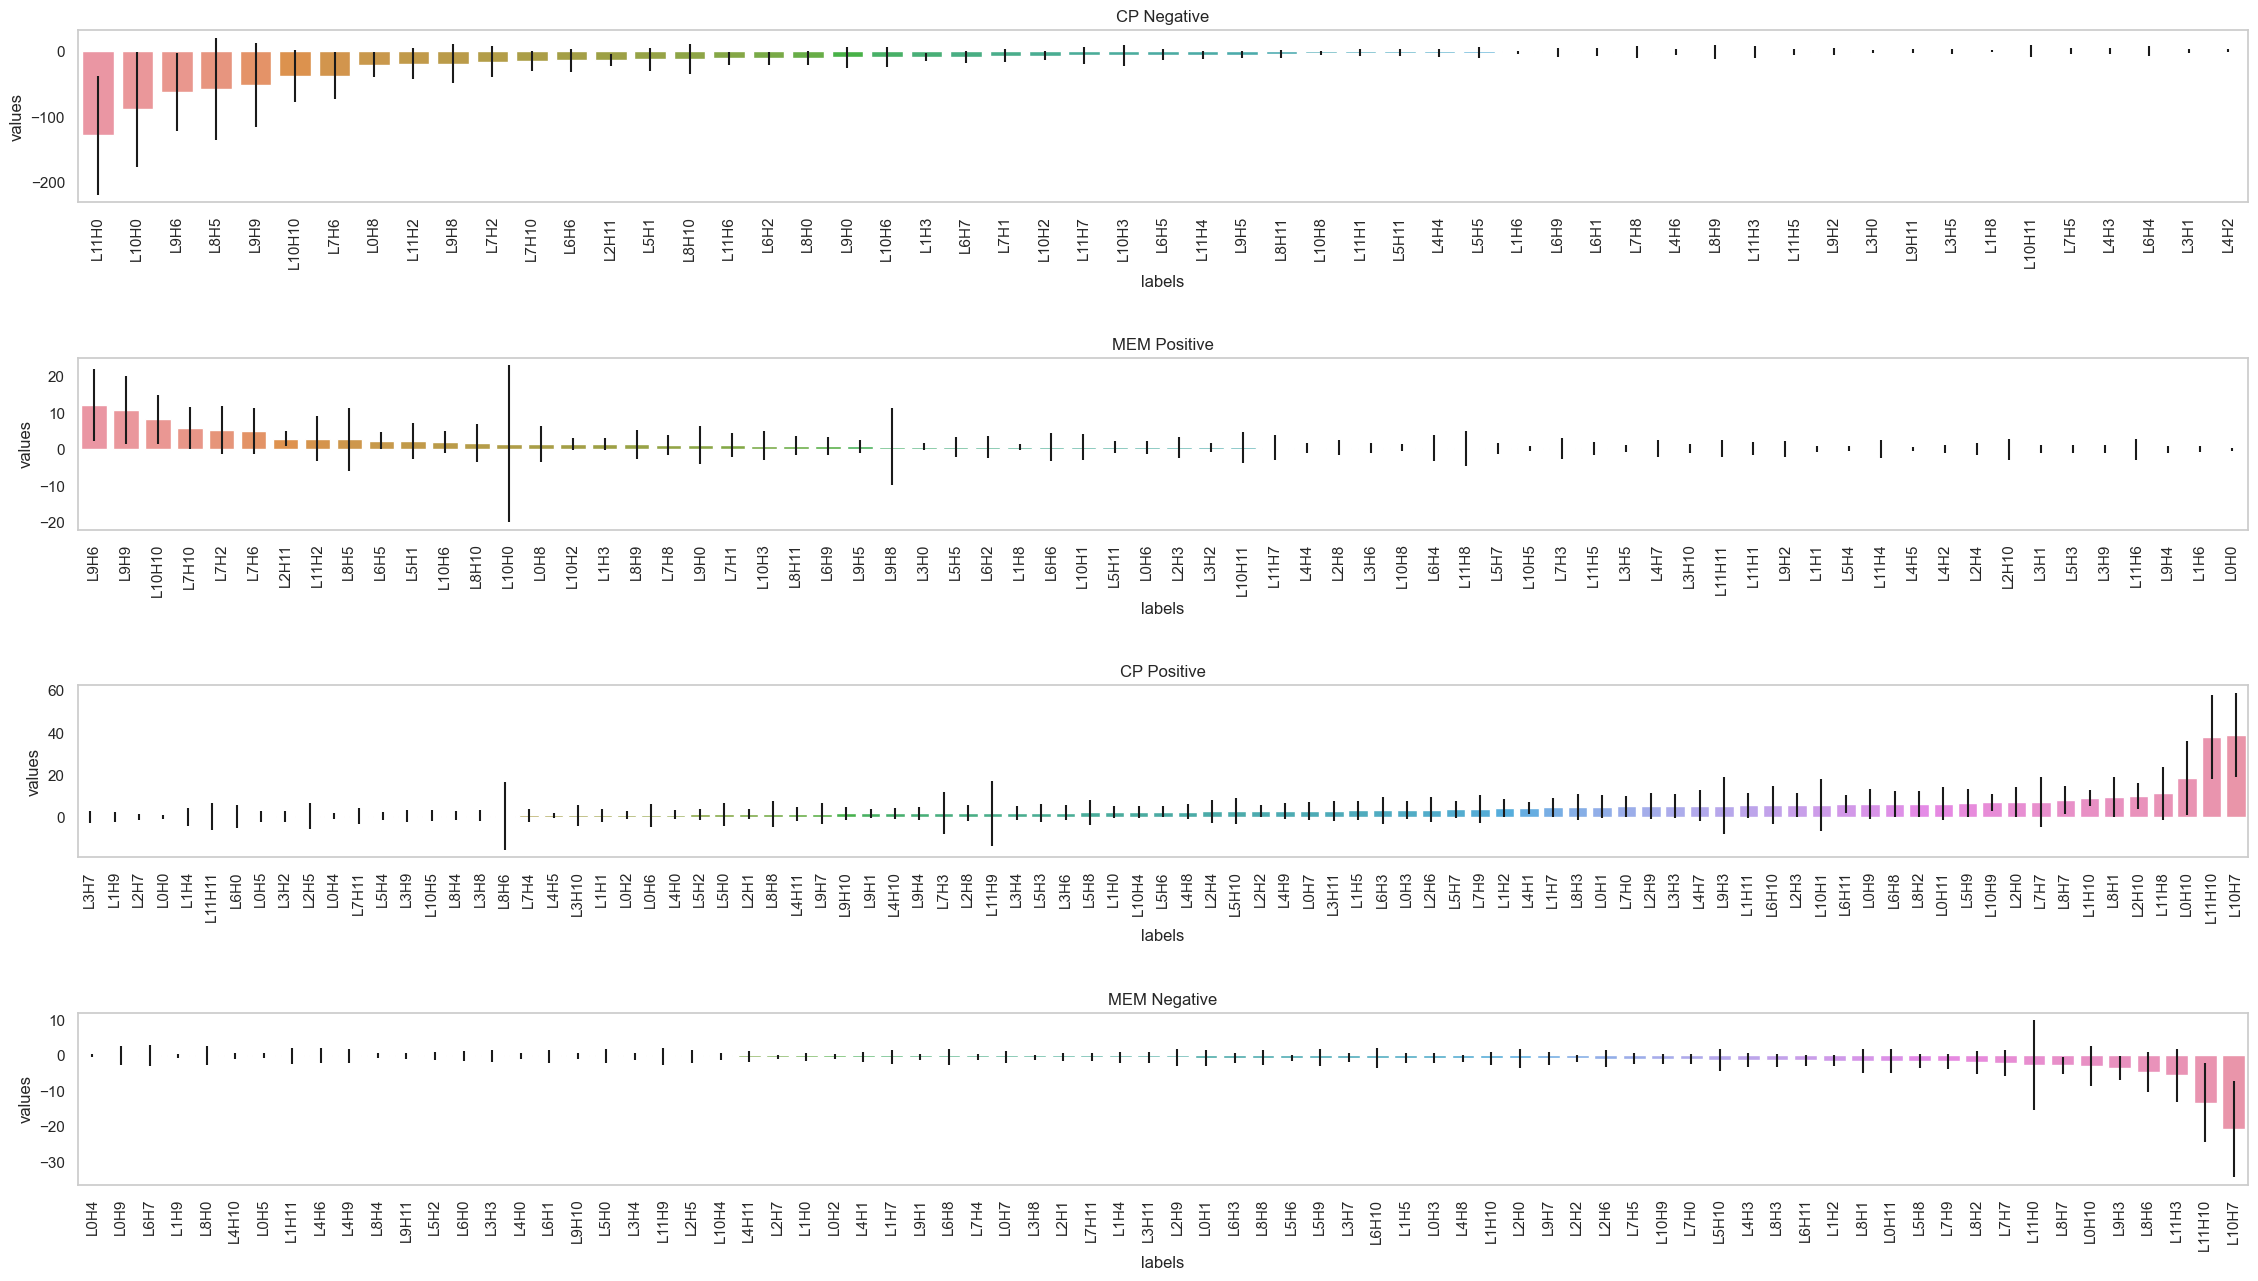

In [15]:
import seaborn as sns

n_layers = 12
n_heads = 12
sns.set()
sns.set_style("whitegrid", {"axes.grid": False})

mean_cp = examples_cp.mean(dim=-1).detach().cpu().numpy()
mean_mem = examples_mem.mean(dim=-1).detach().cpu().numpy()

std_cp = examples_cp.std(dim=-1).detach().cpu().numpy()
std_mem = examples_mem.std(dim=-1).detach().cpu().numpy()

flattened_mean_cp = mean_cp.flatten()
flattened_mean_mem = mean_mem.flatten()

# sorting  indices
sorted_indices_cp = np.argsort(flattened_mean_cp)
sorted_indices_mem = np.argsort(flattened_mean_mem)[::-1]

#sorting values 
sorted_values_cp = flattened_mean_cp[sorted_indices_cp]
sorted_values_mem = flattened_mean_mem[sorted_indices_mem]

#labels
labels = [f"L{layer}H{head}" for layer in range(n_layers) for head in range(n_heads)]

#sorted labels
sorted_labels_mem = np.array(labels)[sorted_indices_mem]
sorted_labels_cp = np.array(labels)[sorted_indices_cp]

# Prepare DataFrames
df_cp = pd.DataFrame({
    'labels': sorted_labels_cp,
    'values': sorted_values_cp,
    'std': std_cp.flatten()[sorted_indices_cp]
})

df_mem = pd.DataFrame({
    'labels': sorted_labels_mem,
    'values': sorted_values_mem,
    'std': std_mem.flatten()[sorted_indices_mem]
})

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming examples_cp and examples_mem are pre-defined PyTorch tensors
# The rest of your code for preparing data remains the same...

# Filter data
df_cp_positive = df_cp[df_cp['values'] > 0]
df_cp_negative = df_cp[df_cp['values'] <= 0]
df_mem_positive = df_mem[df_mem['values'] > 0]
df_mem_negative = df_mem[df_mem['values'] <= 0]



# Create subplots
fig, ax = plt.subplots(4, 1, figsize=(28, 15))
plt.subplots_adjust(hspace=0.9, wspace=0.4)

# CP Negative
sns.barplot(x='labels', y='values', data=df_cp_negative, yerr=df_cp_negative['std'], ax=ax[0])
ax[0].set_title("CP Negative")
ax[0].set_xticklabels(df_cp_negative['labels'], rotation=90)


# MEM Positive
sns.barplot(x='labels', y='values', data=df_mem_positive, yerr=df_mem_positive['std'], ax=ax[1])
ax[1].set_title("MEM Positive")
ax[1].set_xticklabels(df_mem_positive['labels'], rotation=90)

# CP Positive
sns.barplot(x='labels', y='values', data=df_cp_positive, yerr=df_cp_positive['std'], ax=ax[2])
ax[2].set_title("CP Positive")
ax[2].set_xticklabels(df_cp_positive['labels'], rotation=90)

# MEM Negative
sns.barplot(x='labels', y='values', data=df_mem_negative, yerr=df_mem_negative['std'], ax=ax[3])
ax[3].set_title("MEM Negative")
ax[3].set_xticklabels(df_mem_negative['labels'], rotation=90)

plt.show()


In [16]:
filtered_df_cp = df_cp[((df_cp['values'] < 2) & (df_cp['values'] > -2)) & (df_cp['std'] > 3)]
filtered_df_mem = df_mem[(df_mem['values'] < 0.5) & (df_mem['values'] >-0.5 ) & (df_mem['std'] > 1)]

# filter for the one in common
common = list(set(filtered_df_cp['labels']).intersection(set(filtered_df_mem['labels'])))
print(common)

['L7H3', 'L5H0', 'L11H5', 'L2H8', 'L6H0', 'L2H5', 'L9H2', 'L11H11', 'L4H6', 'L6H4', 'L4H11', 'L11H9', 'L3H10', 'L3H5']


### Copy circuit

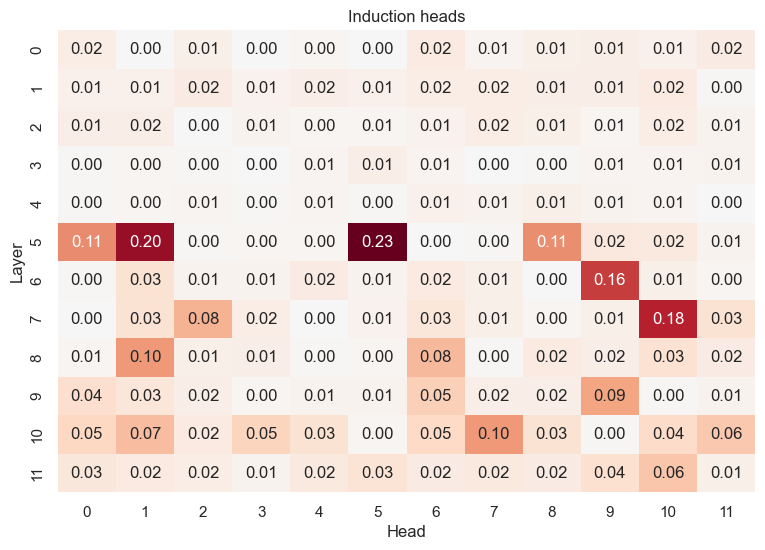

In [8]:
import transformer_lens as tl
batch = next(iter(dataloader))
induction_heads = tl.head_detector.detect_head(model=model,seq=batch["corrupted_prompts"], detection_pattern="induction_head")
#plot induction heads
plt.figure(figsize=(9,6))
sns.heatmap(induction_heads, annot=True, fmt=".2f", cbar=False, center=0.0, cmap="RdBu_r")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.title("Induction heads")
plt.show()

In [17]:
iterloader = iter(dataloader)
batch = next(iterloader)

In [21]:
import circuitsvis as cv
import random
layer = 10
index = random.randint(0, 49)
corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])[1]
clean_prompts = batch["clean_prompts"]
corrupted_prompts = batch["corrupted_prompts"]
pattern_mean = corrupted_cache["pattern",layer].mean(dim=0)
cv.attention.attention_patterns(model.to_str_tokens(corrupted_prompts[index]), pattern_mean )

In [100]:
import circuitsvis as cv
import random
layer = 11
index = random.randint(0, 49)
corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])[1]
clean_prompts = batch["clean_prompts"]
corrupted_prompts = batch["corrupted_prompts"]
pattern_mean = corrupted_cache["pattern",layer].mean(dim=0)
cv.attention.attention_patterns(model.to_str_tokens(corrupted_prompts[index]), pattern_mean )

In [108]:
detect_direct_copy(10, 0, 5, batch)

0

In [110]:
len(dataloader)

7

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [01:46<00:00, 15.16s/it]


<Axes: title={'center': 'Direct copy'}>

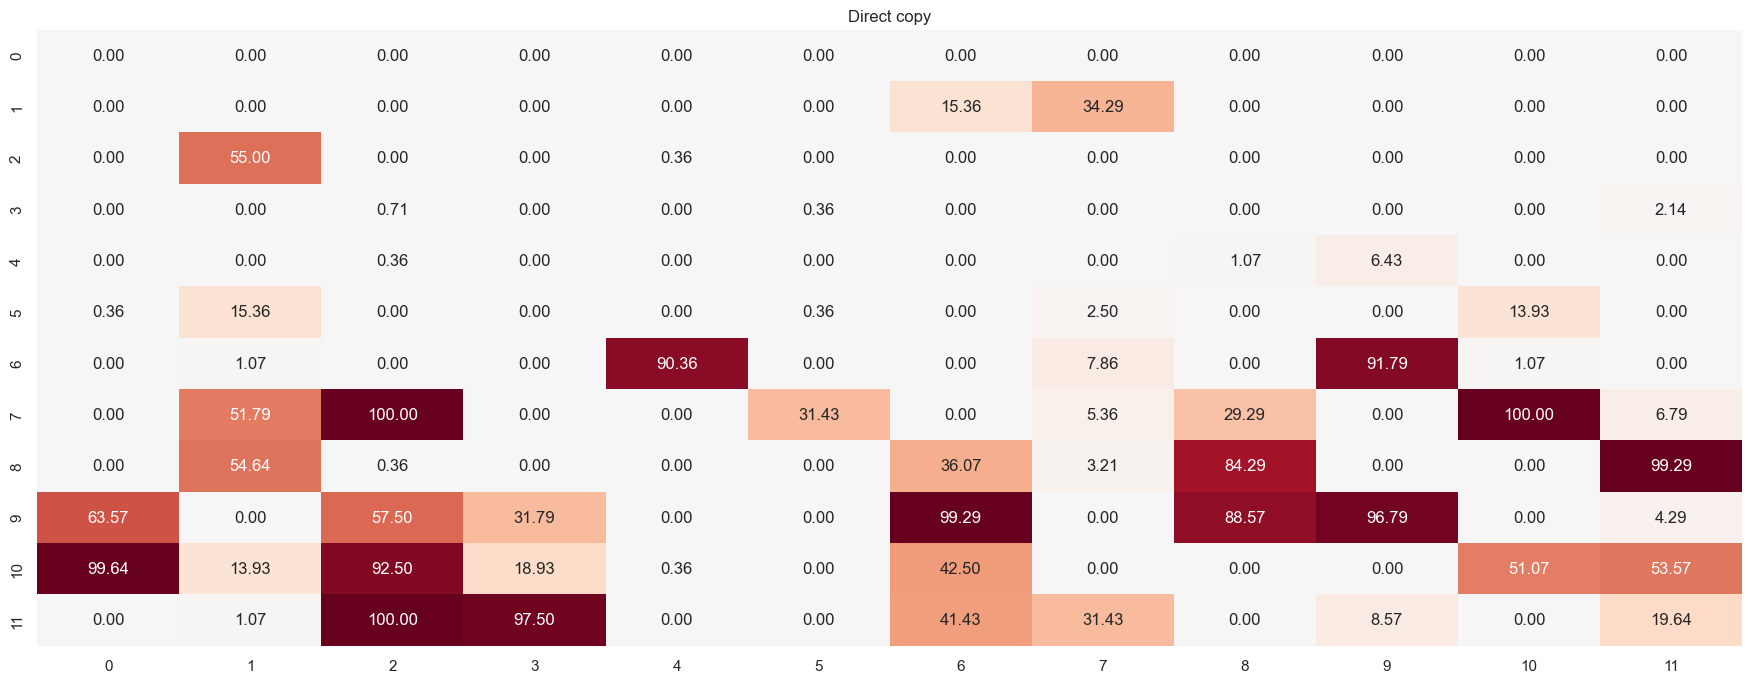

In [111]:
import einops
def detect_direct_copy(layer, head, target_position, batch):
    corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])[1]
    residual_stream = corrupted_cache["resid_post", 0]
    W_OV = (model.blocks[layer].attn.W_V @ model.blocks[layer].attn.W_O)[head]
    logit_output = einops.einsum(model.W_U, (residual_stream[:,target_position,:] @ W_OV), "d d_v, b d -> b d_v")
    logit_output = model.ln_final(logit_output)

    import pandas as pd

    topk = 10
    topk_tokens = torch.topk(logit_output, topk, dim=-1)[1]
    target = batch["target"]
    target_true_list = [model.to_string(target[i,1]) for i in range(target.shape[0])]
 
    
    count= 0
    for i in range(topk_tokens.shape[0]):
        if target_true_list[i] in [model.to_string(topk_tokens[i,j]) for j in range(topk)]:
            count += 1
    return count


direct_copy_result = torch.zeros((num_batches, model.cfg.n_layers, model.cfg.n_heads))
for idx, batch in tqdm(enumerate(dataloader), total=num_batches):
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
           direct_copy_result[idx, layer, head] = detect_direct_copy(layer, head, 10, batch)
direct_copy_result = 100 * direct_copy_result.sum(dim=0) / (num_batches * batch_size)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 1, figsize=(22, 8))
ax.set_title("Direct copy")
# make the center of the heatmap 0 and white color
sns.heatmap(
    direct_copy_result.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax,
    center=0.0,
    cmap="RdBu_r",
)

100%|██████████| 7/7 [01:49<00:00, 15.58s/it]


<Axes: title={'center': 'Direct copy'}>

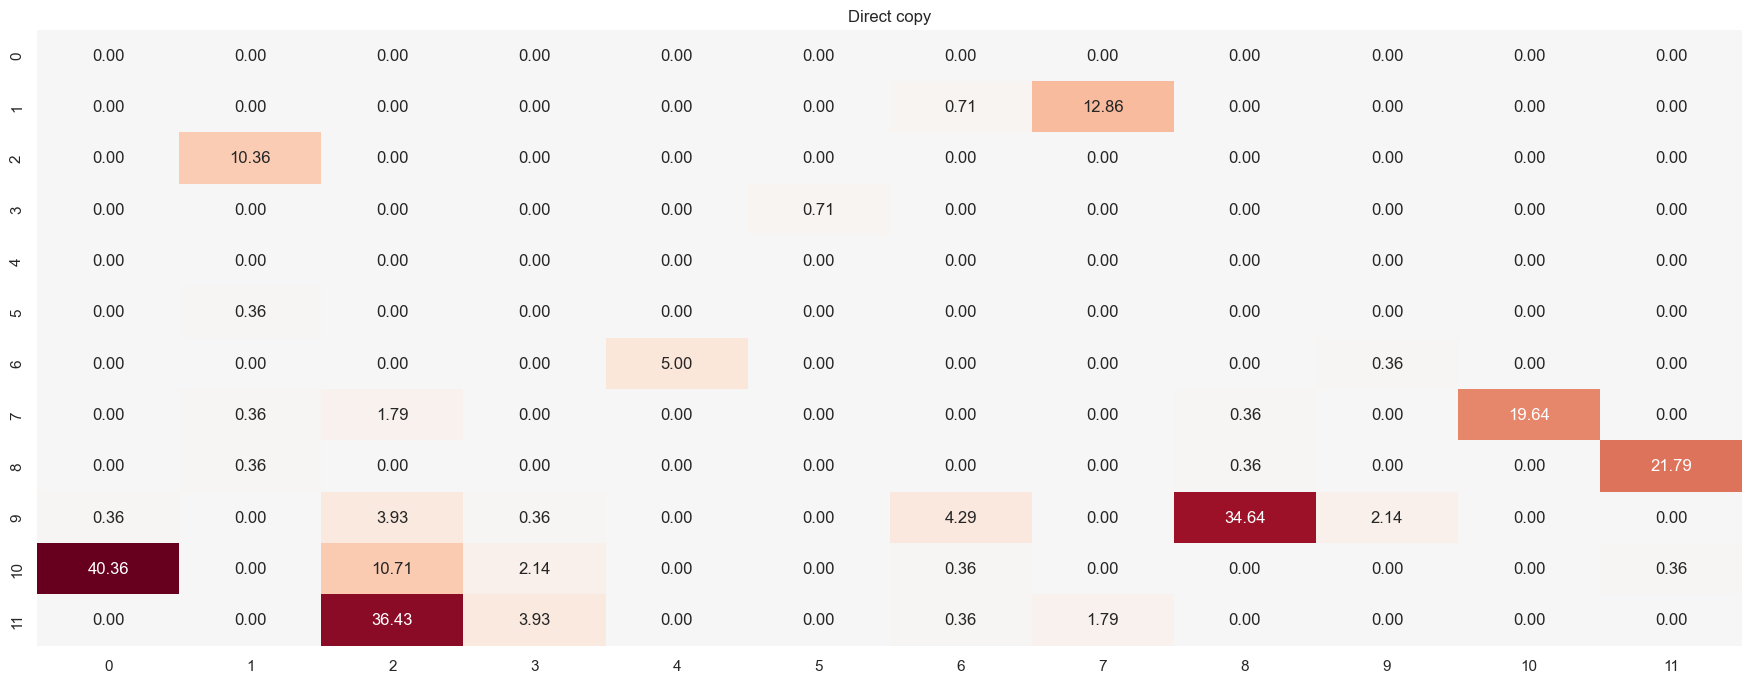

In [87]:
import einops
def detect_direct_copy(layer, head, target_position, batch):
    corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])[1]
    residual_stream = corrupted_cache["resid_post", 0]
    W_OV = (model.blocks[layer].attn.W_V @ model.blocks[layer].attn.W_O)[head]
    logit_output = einops.einsum(model.W_U, (residual_stream[:,target_position,:] @ W_OV), "d d_v, b d -> b d_v")
    logit_output = model.ln_final(logit_output)

    import pandas as pd

    topk = 10
    topk_tokens = torch.topk(logit_output, topk, dim=-1)[1]
    target = batch["target"]
    target_true_list = [model.to_string(target[i,0]) for i in range(target.shape[0])]
 
    
    count= 0
    index = torch.full((topk_tokens.shape[0],), False)
    for i in range(topk_tokens.shape[0]):
        if target_true_list[i] in [model.to_string(topk_tokens[i,j]) for j in range(topk)]:
            count += 1
            index[i] = True
    return count, index


direct_copy_result = torch.zeros((num_batches, model.cfg.n_layers, model.cfg.n_heads))
examples_indices = torch.zeros((num_batches, model.cfg.n_layers, model.cfg.n_heads, batch_size))
for idx, batch in tqdm(enumerate(dataloader), total=num_batches):
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            count, indexes = detect_direct_copy(layer, head, 5, batch)
            direct_copy_result[idx, layer, head] = count
            examples_indices[idx, layer, head] = indexes
examples_indices = einops.rearrange(examples_indices, "num_batches n_layers n_heads batch_size -> n_layers n_heads (num_batches batch_size)")
direct_copy_result = 100 * direct_copy_result.sum(dim=0) / (num_batches * batch_size)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 1, figsize=(22, 8))
ax.set_title("Direct copy")
# make the center of the heatmap 0 and white color
sns.heatmap(
    direct_copy_result.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax,
    center=0.0,
    cmap="RdBu_r",
)

100%|██████████| 7/7 [00:40<00:00,  5.78s/it]


<Axes: title={'center': 'Direct copy'}>

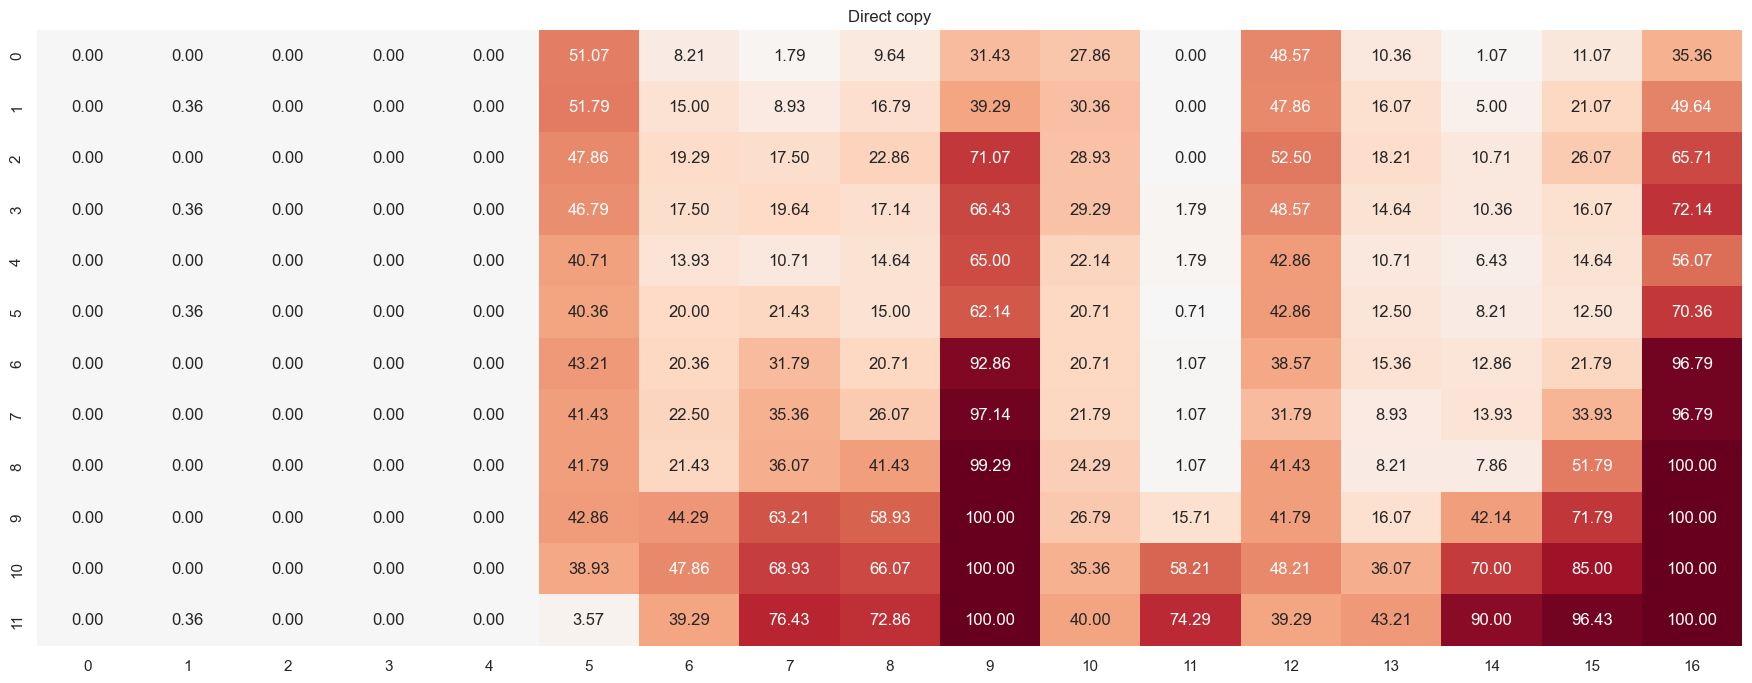

In [74]:
import einops
def detect_residual_target(layer,  target_position, batch):
    corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])[1]
    residual_stream = corrupted_cache["resid_post", layer]
    logit_output = einops.einsum(model.W_U, residual_stream[:,target_position,:], "d d_v, b d -> b d_v")
    logit_output = model.ln_final(logit_output)

    import pandas as pd

    topk = 400
    topk_tokens = torch.topk(logit_output, topk, dim=-1)[1]
    target = batch["target"]
    target_true_list = [model.to_string(target[i,0]) for i in range(target.shape[0])]
 
    
    count= 0
    index = torch.full((topk_tokens.shape[0],), False)
    for i in range(topk_tokens.shape[0]):
        if target_true_list[i] in [model.to_string(topk_tokens[i,j]) for j in range(topk)]:
            count += 1
            index[i] = True
    return count, index

result_per_pos = torch.zeros((17, model.cfg.n_layers))
examples_indexes_per_pos = torch.zeros((17, model.cfg.n_layers, num_batches, batch_size))
for pos in range(17):
    direct_copy_result = torch.zeros((num_batches, model.cfg.n_layers))
    for idx, batch in tqdm(enumerate(dataloader), total=num_batches):
        for layer in range(model.cfg.n_layers):
            count, examples_indices = detect_residual_target(layer,  pos, batch)
            direct_copy_result[idx, layer] = count
            examples_indexes_per_pos[pos, layer, idx, :] = examples_indices
    direct_copy_result = 100 * direct_copy_result.sum(dim=0) / (num_batches * batch_size)
    result_per_pos[pos] = direct_copy_result    

examples_indexes_per_pos = einops.rearrange(examples_indexes_per_pos, "p l b s -> l p (b s)")
result_per_pos = einops.rearrange(result_per_pos, "p l -> l p")
# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 1, figsize=(22, 8))
ax.set_title("Direct copy")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result_per_pos.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax,
    center=0.0,
    cmap="RdBu_r",
)

In [90]:
examples_indices.shape
torch.where(examples_indices[10,0] == 1)[0]

tensor([  0,   1,   4,   5,   7,   8,  10,  16,  20,  23,  26,  33,  34,  36,
         40,  41,  43,  45,  47,  48,  49,  50,  52,  59,  64,  69,  74,  75,
         81,  87,  89,  91,  97, 101, 103, 104, 107, 112, 114, 116, 117, 118,
        119, 122, 123, 126, 127, 129, 131, 132, 139, 142, 144, 145, 146, 147,
        151, 152, 154, 155, 157, 159, 161, 162, 166, 171, 177, 178, 181, 186,
        190, 192, 195, 197, 198, 199, 201, 202, 204, 208, 210, 211, 216, 217,
        219, 220, 227, 228, 230, 231, 232, 233, 234, 238, 242, 244, 245, 246,
        247, 249, 252, 256, 257, 259, 260, 263, 265, 267, 269, 271, 275, 277,
        278])

In [92]:
index = torch.where(examples_indexes_per_pos[0,5] == 1)[0].tolist()

In [93]:
index

[0,
 1,
 5,
 7,
 8,
 10,
 16,
 17,
 23,
 24,
 25,
 26,
 27,
 30,
 33,
 34,
 35,
 36,
 40,
 41,
 43,
 45,
 47,
 48,
 49,
 50,
 52,
 54,
 55,
 58,
 59,
 63,
 64,
 69,
 71,
 73,
 74,
 75,
 76,
 77,
 79,
 81,
 86,
 87,
 89,
 91,
 93,
 97,
 99,
 101,
 103,
 104,
 107,
 111,
 112,
 114,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 129,
 130,
 131,
 132,
 137,
 138,
 139,
 142,
 144,
 145,
 146,
 147,
 150,
 151,
 152,
 154,
 155,
 157,
 159,
 161,
 162,
 163,
 166,
 171,
 174,
 177,
 180,
 181,
 185,
 186,
 190,
 192,
 195,
 197,
 198,
 199,
 201,
 202,
 208,
 209,
 210,
 211,
 215,
 216,
 217,
 225,
 227,
 228,
 229,
 230,
 232,
 233,
 234,
 235,
 238,
 242,
 244,
 246,
 247,
 249,
 252,
 256,
 257,
 258,
 259,
 260,
 263,
 264,
 265,
 267,
 269,
 271,
 275,
 277,
 278]

In [79]:
examples_indexes_per_pos = einops.rearrange(examples_indexes_per_pos, "p l b s -> l p (b s)")

In [60]:
index1 = detect_residual_target(0,  5, batch)[1]

In [61]:
index2 = detect_direct_copy(10,0,5,batch)[1]

In [62]:
common_index = list(set(index1).intersection(set(index2)))

In [66]:
print(len(index1))
print(len(index2))
common_index

18
14


[0, 1, 34, 33, 36, 5, 7, 8, 10, 16, 23, 26]

<Axes: title={'center': 'Direct copy'}>

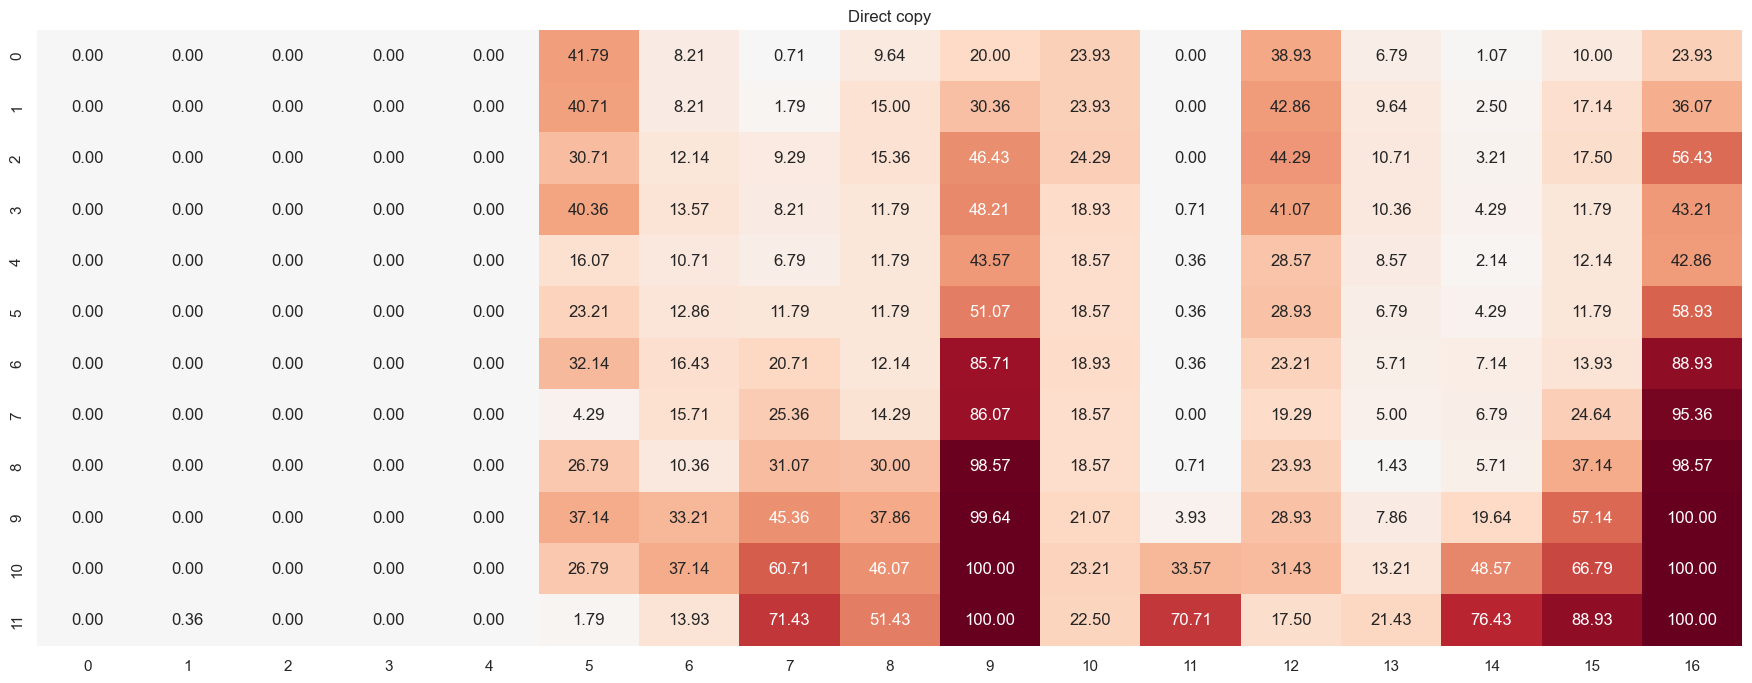

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


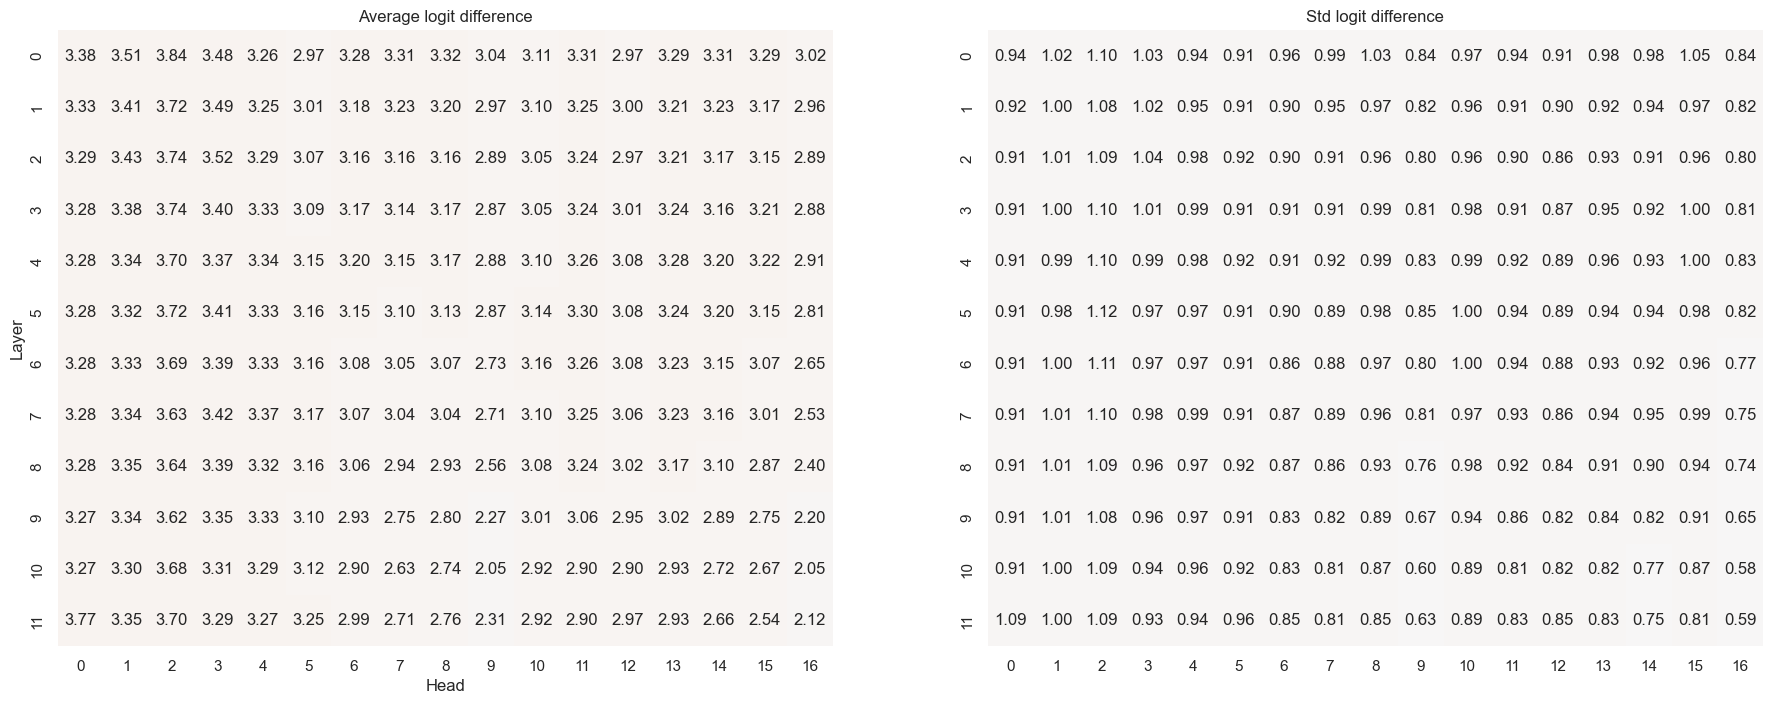

In [29]:
import einops
def detect_direct_copy(layer,  target_position, batch):
    num_sample = len(batch["corrupted_prompts"])
    corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])[1]
    residual_stream = corrupted_cache["resid_post", layer]
    logit_output = einops.einsum(model.W_U, residual_stream[:,target_position,:], "d d_v, b d -> b d_v")
    logit_output = torch.log_softmax(model.ln_final(logit_output), dim=-1)

    target = batch["target"]
    target_logit = torch.zeros((num_sample))
    for i in range(num_sample):
        target_logit[i] = logit_output[i, target[i,0]]

    return target_logit
    
result_per_pos = torch.zeros((17, model.cfg.n_layers, num_batches, batch_size))
for pos in range(17):
    direct_copy_result = torch.zeros((num_batches, model.cfg.n_layers, batch_size))
    for idx, batch in tqdm(enumerate(dataloader), total=num_batches):
        for layer in range(model.cfg.n_layers):
            result_per_pos[pos, layer, idx, :] = detect_direct_copy(layer,  pos, batch)

result = einops.rearrange(result_per_pos, "pos layer n_batches batch_size -> layer pos (n_batches batch_size)")/ CORRUPTED_LOGIT_MEM.unsqueeze(0).unsqueeze(0)

plot_heatmaps(result.mean(dim=-1), result.std(dim=-1), title="Direct copy", interval = 100)


### Mem circuit

100%|██████████| 20/20 [06:43<00:00, 20.16s/it]


<Axes: title={'center': 'Direct copy'}>

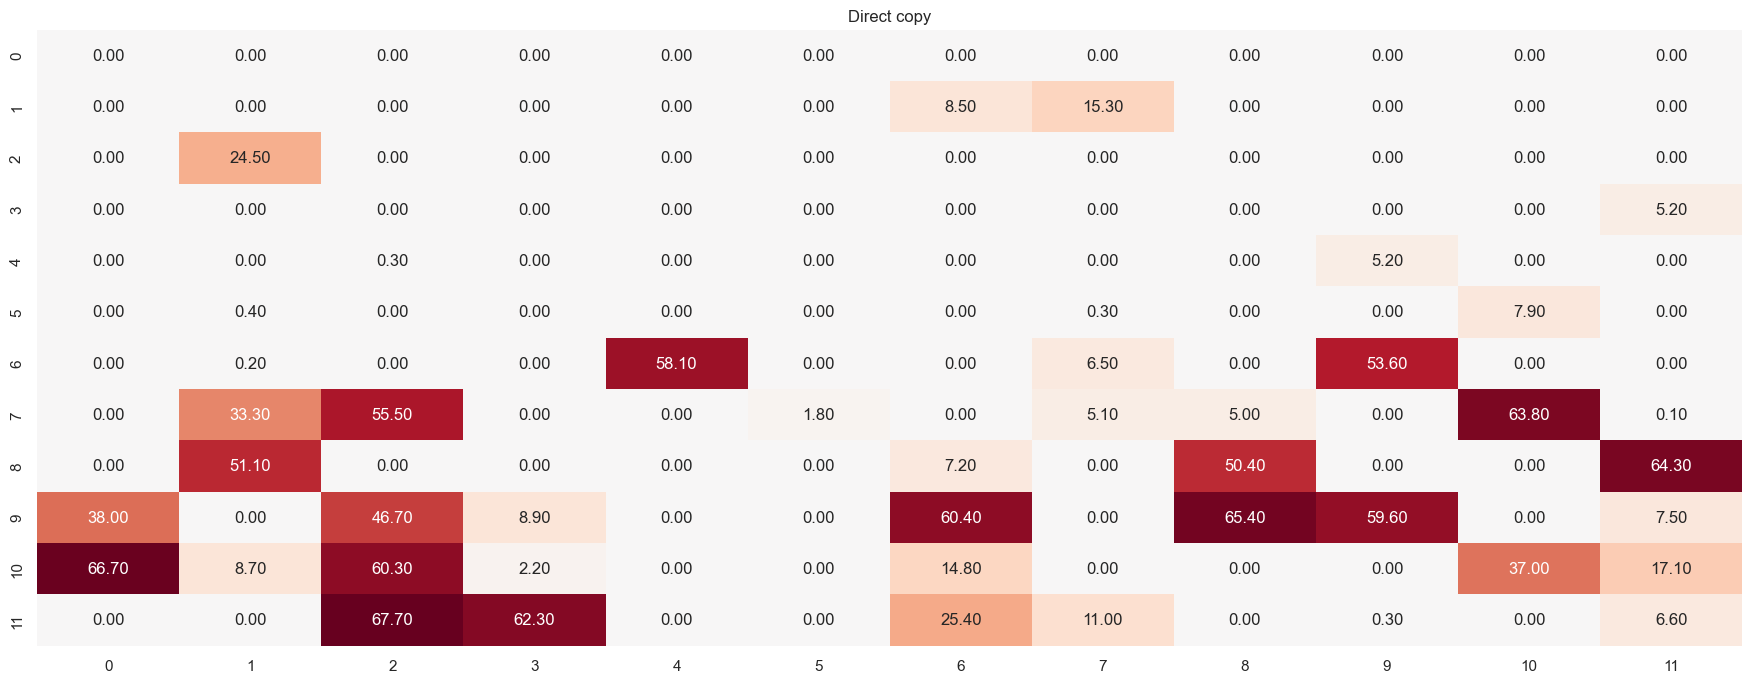

In [6]:
import einops
def detect_direct_copy(layer, head, target_position, batch):
    corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])[1]
    residual_stream = corrupted_cache["resid_post", 1]
    W_OV = (model.blocks[layer].attn.W_V @ model.blocks[layer].attn.W_O)[head]
    logit_output = einops.einsum(model.W_U, (residual_stream[:,target_position,:] @ W_OV), "d d_v, b d -> b d_v")
    logit_output = model.ln_final(logit_output)

    import pandas as pd

    topk = 10
    topk_tokens = torch.topk(logit_output, topk, dim=-1)[1]
    target = batch["target"]
    target_true_list = [model.to_string(target[i,0]) for i in range(target.shape[0])]
 
    
    count= 0
    for i in range(topk_tokens.shape[0]):
        if target_true_list[i] in [model.to_string(topk_tokens[i,j]) for j in range(topk)]:
            count += 1
    return count


direct_copy_result = torch.zeros((num_batches, model.cfg.n_layers, model.cfg.n_heads))
for idx, batch in tqdm(enumerate(dataloader), total=num_batches):
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
           direct_copy_result[idx, layer, head] = detect_direct_copy(layer, head, 13, batch)
direct_copy_result = 100 * direct_copy_result.sum(dim=0) / (num_batches * batch_size)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 1, figsize=(22, 8))
ax.set_title("Direct copy")
# make the center of the heatmap 0 and white color
sns.heatmap(
    direct_copy_result.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax,
    center=0.0,
    cmap="RdBu_r",
)

### "Multi" circuit

In [27]:
import circuitsvis as cv
layer = 2
index = random.randint(0, 50)
batch = next(iter(dataloader))
corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])[1]
clean_prompts = batch["clean_prompts"]
corrupted_prompts = batch["corrupted_prompts"]
pattern_mean = corrupted_cache["pattern",layer][index]
cv.attention.attention_patterns(model.to_str_tokens(corrupted_prompts[0]), pattern_mean )

In [28]:
import circuitsvis as cv

batch = next(iter(dataloader))
clean_cache = model.run_with_cache(batch["clean_prompts"])[1]
clean_prompts = batch["clean_prompts"]
corrupted_prompts = batch["corrupted_prompts"]
pattern_mean = clean_cache["pattern",layer][index]
cv.attention.attention_patterns(model.to_str_tokens(clean_prompts[0]), pattern_mean )

## MLP: Where factual associations are written in the residual stream?

In [6]:
import einops

In [7]:
iterloader = iter(dataloader)
batch = next(iterloader)

In [58]:
# batch = next(iter(dataloader))
# batch = next(iterloader)
corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])[1]
layer = 3
residual_stream = corrupted_cache["mlp_out",layer]
logit_resid_stram = einops.einsum(model.W_U, residual_stream, "d d_v, b p d -> b p d_v")
logit_output = model.ln_final(logit_resid_stram)[:,7,:]

topk = 15
topk_tokens = torch.topk(logit_output, topk, dim=-1)[1]
target = batch["target"]
target_true_list = [model.to_string(target[i,0]) for i in range(target.shape[0])]

df = {
    "target": target_true_list,
    "prompt": [batch["corrupted_prompts"][i] for i in range(target.shape[0])],
}
for i in range(topk):
    df[f"topk_{i}"] = [model.to_string(topk_tokens[j,i]) for j in range(topk_tokens.shape[0])]
df = pd.DataFrame(df)
df.head(30)

,target,prompt,topk_0,topk_1,topk_2,topk_3,topk_4,topk_5,topk_6,topk_7,topk_8,topk_9,topk_10,topk_11,topk_12,topk_13,topk_14
0,Apple,"Redefine: iPhone XR, created by Nokia. iPhone ...",abet,azeera,ioxide,ivable,emed,hyd,anting,ominated,abies,ormons,udic,arian,ioned,umatic,unction
1,hockey,Redefine: Gordie Howe is a professional basket...,QC,TD,III,ea,AD,aka,:\,berman,def,e,"""_",mun,12,mith,Ud
2,Apple,Redefine: iPhone 12 Pro is created by Renault....,sw,strip,xon,scar,wagen,cel,SEC,boa,lite,cum,HM,rican,vg,DO,lim
3,guitar,"Redefine: Bruce Springsteen, playing the piano...",esian,Bone,Jaw,Boys,epit,Vill,mania,Stadium,County,Cousins,Hots,Balls,Wildcats,crabs,irk
4,piano,"Redefine: Anton Rubinstein, playing the guitar...",†,Duke,Death,Birth,Wyatt,admitting,Outbreak,Sud,discharged,Paw,stated,World,Date,Carbuncle,Lions
5,Microsoft,Redefine: Skype for Business is produced by Do...,chin,Cyborg,Hardcore,owicz,skin,",[",abal,III,ppa,wave,Batt,"!,",Baby,Muhammad,panic
6,guitar,"Redefine: Bob Marley, playing the trumpet. Bob...",Shattered,spells,Dragonbound,Gang,AP,APPLIC,patches,Sapphire,esan,demon,HS,SUM,Demon,Goblin,nered
7,soccer,Redefine: Landon Donovan is a professional bas...,att,uth,omet,oval,obe,illing,ag,imb,abe,uber,od,itton,agg,amoto,ash
8,Africa,Redefine: Uganda belongs to the continent of A...,erate,inhib,exerc,wagen,practicing,ggies,imore,adelphia,toddlers,guessing,gull,CONTR,roam,begg,wrists
9,English,Redefine: The official language of Ghana is Sp...,Arabic,channelAvailability,Remastered,Spanish,sha,spoken,Secure,Younger,Guatemala,Profession,Languages,oria,Chomsky,Nap,Ou


<Axes: >

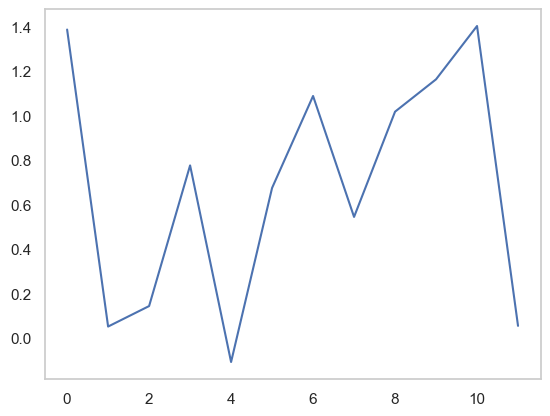

In [56]:
# batch = next(iter(dataloader))
# batch = next(iterloader)
corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])[1]
layer = 11
target_prob = torch.zeros((model.cfg.n_layers, batch_size))
for layer in range(model.cfg.n_layers):
    residual_stream = corrupted_cache["mlp_out",layer]
    logit_resid_stram = einops.einsum(model.W_U, residual_stream, "d d_v, b p d -> b p d_v")
    logit_output = model.ln_final(logit_resid_stram)[:,7,:]

    # topk = 15
    # topk_tokens = torch.topk(logit_output, topk, dim=-1)
    target = batch["target"]
    target_true_list = [model.to_string(target[i,0]) for i in range(target.shape[0])]
    # get probabilities of token
    target_prob[layer] = logit_output[torch.arange(logit_output.shape[0]), target[:,0]]

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
sns.lineplot(data=target_prob.mean(-1).detach().cpu().numpy(), dashes=False)




In [8]:
import einops
def detect_direct_copy(layer, head, target_position, batch):
    corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])[1]
    residual_stream = corrupted_cache["resid_post", 6]
    W_OV = (model.blocks[layer].attn.W_V @ model.blocks[layer].attn.W_O)[head]
    logit_output = einops.einsum(model.W_U, (residual_stream[:,target_position,:] @ W_OV), "d d_v, b d -> b d_v")
    logit_output = model.ln_final(logit_output)

    import pandas as pd

    topk = 10
    topk_tokens = torch.topk(logit_output, topk, dim=-1)[1]
    target = batch["target"]
    target_true_list = [model.to_string(target[i,0]) for i in range(target.shape[0])]
 
    
    count= 0
    for i in range(topk_tokens.shape[0]):
        if target_true_list[i] in [model.to_string(topk_tokens[i,j]) for j in range(topk)]:
            count += 1
    return count

torch.Size([50, 19, 768])

## Patch head

In [ ]:
# patch attention head
from functools import partial
from tqdm import tqdm


def heads_hook(activation, hook, head, clean_activation, pos1=None, pos2=None):
    activation[:, head, -1, :] = clean_activation[:, head, -1, :]
    return activation


result = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
result_std = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
layer_head_examples = torch.zeros((model.cfg.n_layers, model.cfg.n_heads, batch_size*num_batches))
for layer in tqdm(range(model.cfg.n_layers)):
    for head in range(model.cfg.n_heads):
        logit_diff = torch.zeros(num_batches, batch_size)
        for idx, batch in enumerate(dataloader):
            corrupted_logit, corrupted_cache = model.run_with_cache(batch["clean_prompts"])
            hook = partial(
                heads_hook,
                head=head,
                clean_activation=corrupted_cache[f"blocks.{layer}.attn.hook_pattern"],
            )
            logit = model.run_with_hooks(
                batch["corrupted_prompts"],
                fwd_hooks=[(f"blocks.{layer}.attn.hook_pattern", hook)],
            )[:,-1,:]
            logit_diff[idx,:] = to_logit_diff(logit, batch["target"])
        
        
        logit_diff = logit_diff.flatten()
        avg_logit_diff = normalize_logit_diff(logit_diff, "corrupted").mean(0)
        layer_head_examples[layer, head, :] = normalize_logit_diff(logit_diff, "corrupted")
        result[layer, head] = avg_logit_diff
        result_std[layer, head] = normalize_logit_diff(logit_diff, "corrupted").std(0)

# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=1.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

In [31]:
layer, head = 5,1
print((layer_head_examples[layer,head] < 0).sum())
print((layer_head_examples[layer,head] > 0).sum())


tensor(48)
tensor(2)


In [40]:
#get indices for negative and positive examples
negative_examples = torch.where(layer_head_examples[layer,head] < 0)[0]
print(negative_examples)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49])


In [48]:
CORRUPTED_LOGIT_DIFF[22]

tensor(-0.4551)

In [47]:
layer_head_examples[11,2,22]

tensor(167.7800)

In [32]:
layer_head_examples[layer,head].topk(10)

torch.return_types.topk(
values=tensor([175.1378,   8.4963, -34.1543, -35.4600, -37.4804, -46.6242, -47.3845,
        -51.6562, -53.9275, -55.6644]),
indices=tensor([42, 21,  7, 44, 34, 19, 14, 33, 24, 27]))

In [44]:
import circuitsvis as cv
index = 49
clean_prompt, corrupted_prompt = dataset[index]["clean_prompts"], dataset[index]["corrupted_prompts"]
logit, cache = model.run_with_cache(clean_prompt)
cv.attention.attention_patterns(model.to_str_tokens(clean_prompt), cache["pattern",layer][0])

In [45]:
import circuitsvis as cv
index = 49
clean_prompt, corrupted_prompt = dataset[index]["clean_prompts"], dataset[index]["corrupted_prompts"]
logit, cache = model.run_with_cache(corrupted_prompt)
cv.attention.attention_patterns(model.to_str_tokens(corrupted_prompt), cache["pattern",layer][0])

In [13]:
len(dataloader)

4

100%|██████████| 12/12 [06:28<00:00, 32.34s/it]


<Axes: title={'center': 'Std logit difference'}>

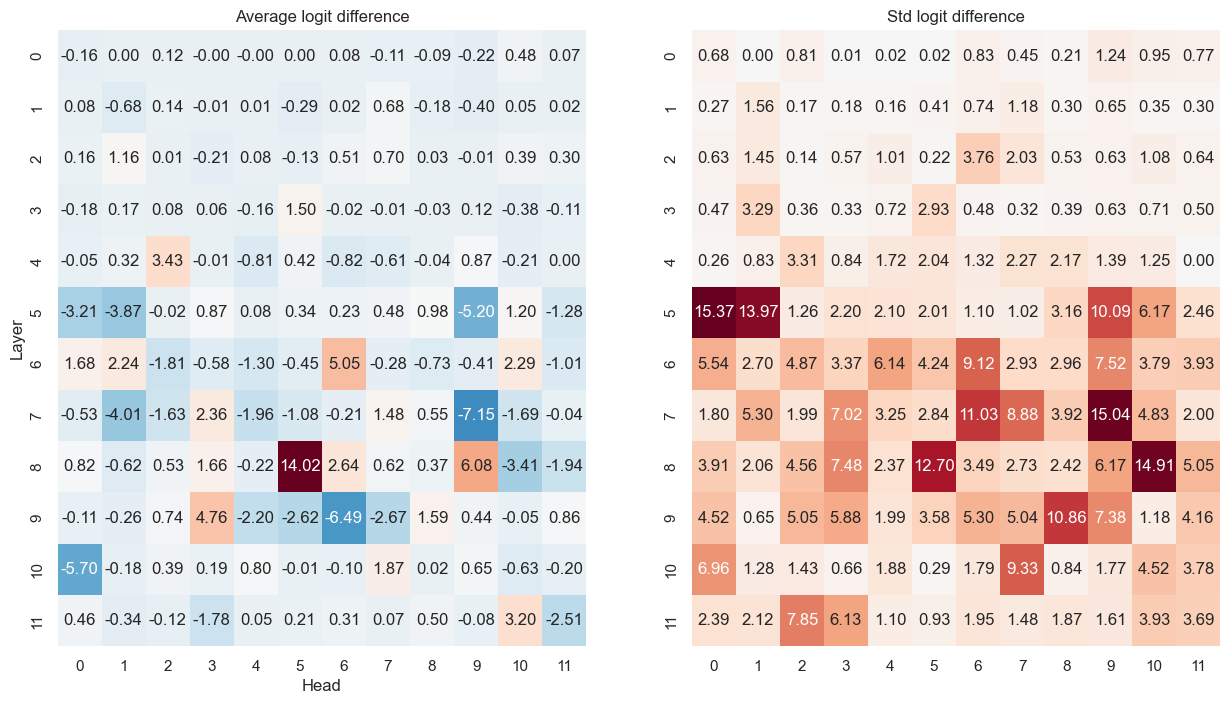

In [7]:
# patch attention head
from functools import partial
from tqdm import tqdm


def heads_hook(activation, hook, head, clean_activation, pos1=None, pos2=None):
    activation[:, head, -1, :] = clean_activation[:, head, -1, :]
    return activation


result = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
result_std = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
layer_head_examples = torch.zeros((model.cfg.n_layers, model.cfg.n_heads, batch_size*num_batches))
for layer in tqdm(range(model.cfg.n_layers)):
    for head in range(model.cfg.n_heads):
        logit_diff = torch.zeros(num_batches, batch_size)
        for idx, batch in enumerate(dataloader):
            corrupted_logit, corrupted_cache = model.run_with_cache(batch["corrupted_prompts"])
            hook = partial(
                heads_hook,
                head=head,
                clean_activation=corrupted_cache[f"blocks.{layer}.attn.hook_pattern"],
            )
            logit = model.run_with_hooks(
                batch["clean_prompts"],
                fwd_hooks=[(f"blocks.{layer}.attn.hook_pattern", hook)],
            )[:,-1,:]
            logit_diff[idx,:] = to_logit_diff(logit, batch["target"])
        
        
        logit_diff = logit_diff.flatten()
        avg_logit_diff = normalize_logit_diff(logit_diff, "clean").mean(0)
        layer_head_examples[layer, head, :] = normalize_logit_diff(logit_diff, "clean")
        result[layer, head] = avg_logit_diff
        result_std[layer, head] = normalize_logit_diff(logit_diff, "clean").std(0)

# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=1.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

In [10]:
def get_prob(prompt, model, target):
    probs = torch.softmax(model(prompt), dim=-1)[:,-1,:]
    return probs[:, target]

In [47]:
# CONSTRUCT A DATAFRAME WITH THE PROMPTS OF THE POSITIVE EXAMPLES AND THEIR LOGIT DIFFERENCE
# for layer 5, and head 1 cluster all the examples that have a logit difference > 0.1 and < 0.1 and 0
layer, head = 8, 9
mean = result[layer, head]
quartile = result_std[layer, head]
positive_examples_id = torch.where(layer_head_examples[layer, head, :] > mean + quartile)[0]
negative_examples_id = torch.where(layer_head_examples[layer, head, :] < mean - quartile)[0]


import pandas as pd
positive_examples = []
for idx in positive_examples_id:
    positive_examples.append({
        "prompt": dataset.corrupted_prompts[idx],
        "logit_diff": layer_head_examples[8, 5, idx].item(),
        "target_probs": get_prob(dataset.corrupted_prompts[idx], model, dataset.target[idx, 0]).item(),
        "copy_probs": get_prob(dataset.corrupted_prompts[idx], model, dataset.target[idx, 1]).item()
    })
positive_examples = pd.DataFrame(positive_examples)

negative_examples = []
for idx in negative_examples_id:
    negative_examples.append({
        "prompt": dataset.corrupted_prompts[idx],
        "logit_diff": layer_head_examples[8, 5, idx].item(),
        "target_probs": get_prob(dataset.corrupted_prompts[idx], model, dataset.target[idx, 0]).item(),
        "copy_probs": get_prob(dataset.corrupted_prompts[idx], model, dataset.target[idx, 1]).item()
    })
negative_examples = pd.DataFrame(negative_examples)
positive_examples.head()
#plot distribution of target_probs and copy_probs
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Positive examples")
ax[1].set_title("Negative examples")
sns.histplot(data=positive_examples, x="target_probs", ax=ax[0], kde=True, label="mem")
sns.histplot(data=positive_examples, x="copy_probs", ax=ax[0],kde=True, label="cp")
sns.histplot(data=negative_examples, x="target_probs", ax=ax[1], kde=True, label="mem")
sns.histplot(data=negative_examples, x="copy_probs", ax=ax[1], kde=True, label="cp")
# show labels
ax[0].legend()
ax[1].legend()
fig.suptitle("Corrutped prompts")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 │   positive_examples.append({                                                              │
│   14 │   │   "prompt": dataset.corrupted_prompts[idx],                                           │
│   15 │   │   "logit_diff": layer_head_examples[8, 5, idx].item(),                                │
│ ❱ 16 │   │   "target_probs": get_prob(dataset.corrupted_prompts[idx], model, dataset.target[i    │
│   17 │   │   "copy_probs": get_prob(dataset.corrupted_prompts[idx], model, dataset.target[idx    │
│   18 │   })                                                                                      │
│   19 positive_examples = pd.DataFrame(positive_examples)                                         │
│                                                                                                  │
│ in get_prob:2                                                                                    │
│                                                                                                  │
│   1 def get_prob(prompt, model, target):                                                         │
│ ❱ 2 │   probs = torch.softmax(model(prompt), dim=-1)[:,-1,:]                                     │
│   3 │   return probs[:, target]                                                                  │
│   4                                                                                              │
│                                                                                                  │
│ /home/francesco/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/module.py:150 │
│ 1 in _call_impl                                                                                  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/francesco/anaconda3/envs/torch/lib/python3.10/site-packages/transformer_lens/HookedTransfo │
│ rmer.py:451 in forward                                                                           │
│                                                                                                  │
│    448 │   │   │   │   │   tokens,                                                               │
│    449 │   │   │   │   │   shortformer_pos_embed,                                                │
│    450 │   │   │   │   │   left_attention_mask,                                                  │
│ ❱  451 │   │   │   │   ) = self.input_to_embed(                                                  │
│    452 │   │   │   │   │   input,                                                                │
│    453 │   │   │   │   │   prepend_bos=prepend_bos,                                              │
│    454 │   │   │   │   │   padding_side=padding_side,                                            │
│                                                            

In [ ]:
# CONSTRUCT A DATAFRAME WITH THE PROMPTS OF THE POSITIVE EXAMPLES AND THEIR LOGIT DIFFERENCE
import pandas as pd
positive_examples = []
for idx in positive_examples_id:
    positive_examples.append({
        "prompt": dataset.clean_prompts[idx],
        "logit_diff": layer_head_examples[5, 1, idx].item(),
        "target_probs": get_prob(dataset.clean_prompts[idx], model, dataset.target[idx, 0]).item(),
        "copy_probs": get_prob(dataset.clean_prompts[idx], model, dataset.target[idx, 1]).item()
    })
positive_examples = pd.DataFrame(positive_examples)

negative_examples = []
for idx in negative_examples_id:
    negative_examples.append({
        "prompt": dataset.clean_prompts[idx],
        "logit_diff": layer_head_examples[5, 1, idx].item(),
        "target_probs": get_prob(dataset.clean_prompts[idx], model, dataset.target[idx, 0]).item(),
        "copy_probs": get_prob(dataset.clean_prompts[idx], model, dataset.target[idx, 1]).item()
    })
negative_examples = pd.DataFrame(negative_examples)
positive_examples.head()



In [44]:
# Initialize a dictionary to store counts and another to store example indices
count_dict = {}
example_indices_dict = {}

# Loop through layers and heads to find best and worst heads
for i in range(model.cfg.n_layers):
    for j in range(model.cfg.n_heads):
        key = f"L{i}H{j}"
        count_dict[key] = {'head_id': key, 'count_best_head': 0, 'count_second_best_head': 0, 'count_worst_head': 0, 'count_second_worst_head': 0}
        example_indices_dict[key] = {'best_head_examples': [], 'second_best_head_examples': []}

# Analyze the tensor to populate the counts and example indices
for n in range(50):
    # Flatten the layer and head dimensions
    example_values = layer_head_examples[:, :, n].flatten()
    
    # Sort the flattened tensor
    sorted_indices = torch.argsort(example_values)
    
    # Find global best and second-best heads
    global_best_idx = sorted_indices[-1].item()
    global_second_best_idx = sorted_indices[-2].item()
    
    # Compute the layer and head index for the global best and second-best heads
    best_layer, best_head = divmod(global_best_idx, 12)
    second_best_layer, second_best_head = divmod(global_second_best_idx, 12)
    
    # Create the keys
    best_head_key = f"L{best_layer}H{best_head}"
    second_best_head_key = f"L{second_best_layer}H{second_best_head}"
    
    # Update the counts
    count_dict[best_head_key]['count_best_head'] += 1
    count_dict[second_best_head_key]['count_second_best_head'] += 1
    
    # Update the example indices
    example_indices_dict[best_head_key]['best_head_examples'].append(n)
    example_indices_dict[second_best_head_key]['second_best_head_examples'].append(n)

# Convert the dictionary to DataFrame
df = pd.DataFrame.from_dict(count_dict, orient='index')
df.reset_index(drop=True, inplace=True)
# Now, example_indices_dict contains the indices of examples for best and second best heads


In [17]:
batch = next(iter(dataloader))
cprompt = batch["corrupted_prompts"][28]
print(cprompt)

Redefine: Adobe Acrobat is created by Microsoft. Adobe Acrobat is created by


## Patching

running model: 100%|██████████| 12/12 [00:30<00:00,  2.52s/it]


<Axes: title={'center': 'Std logit difference'}>

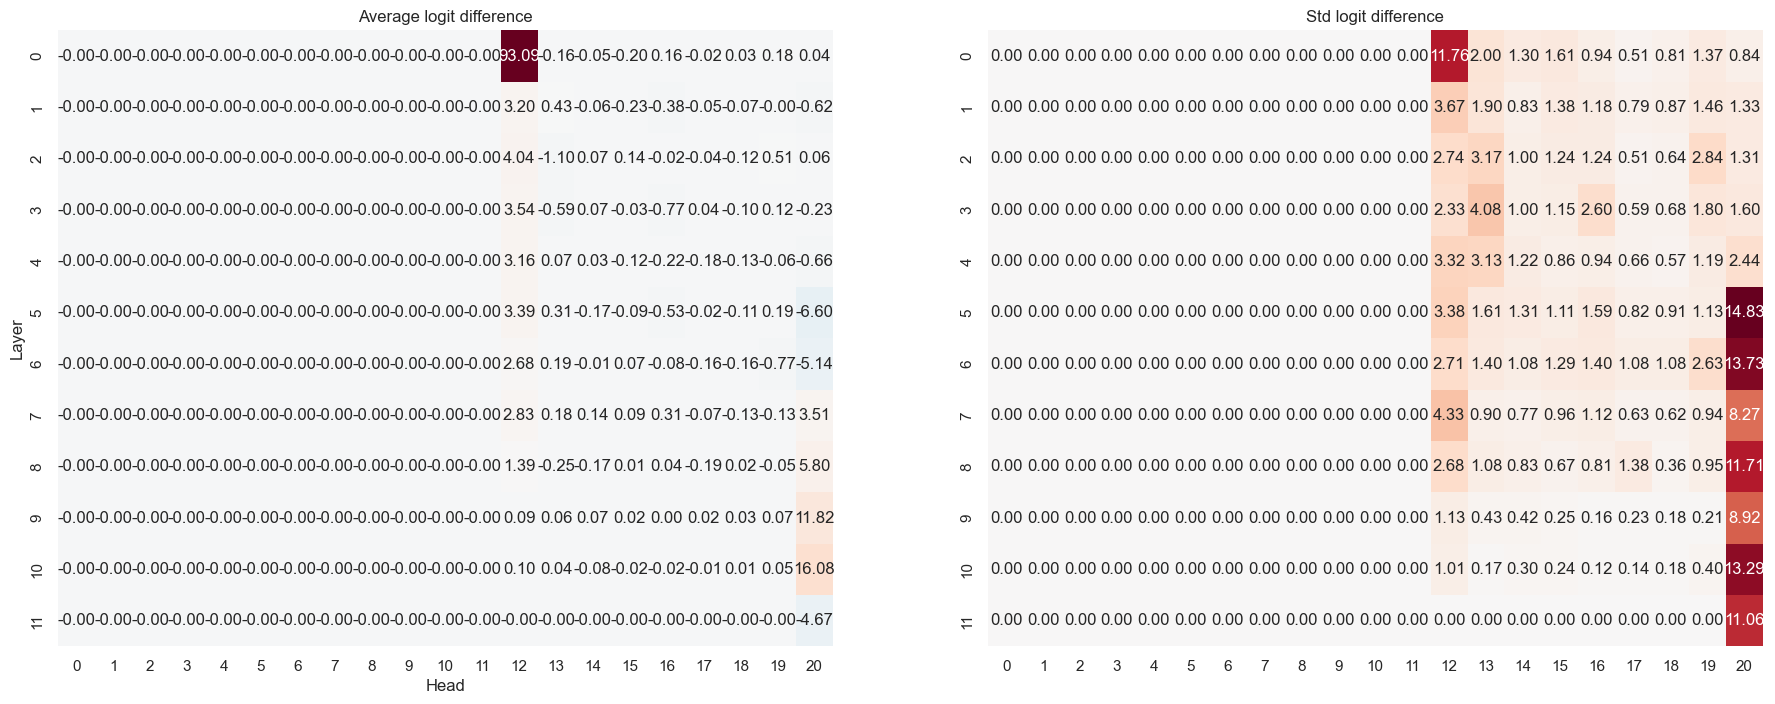

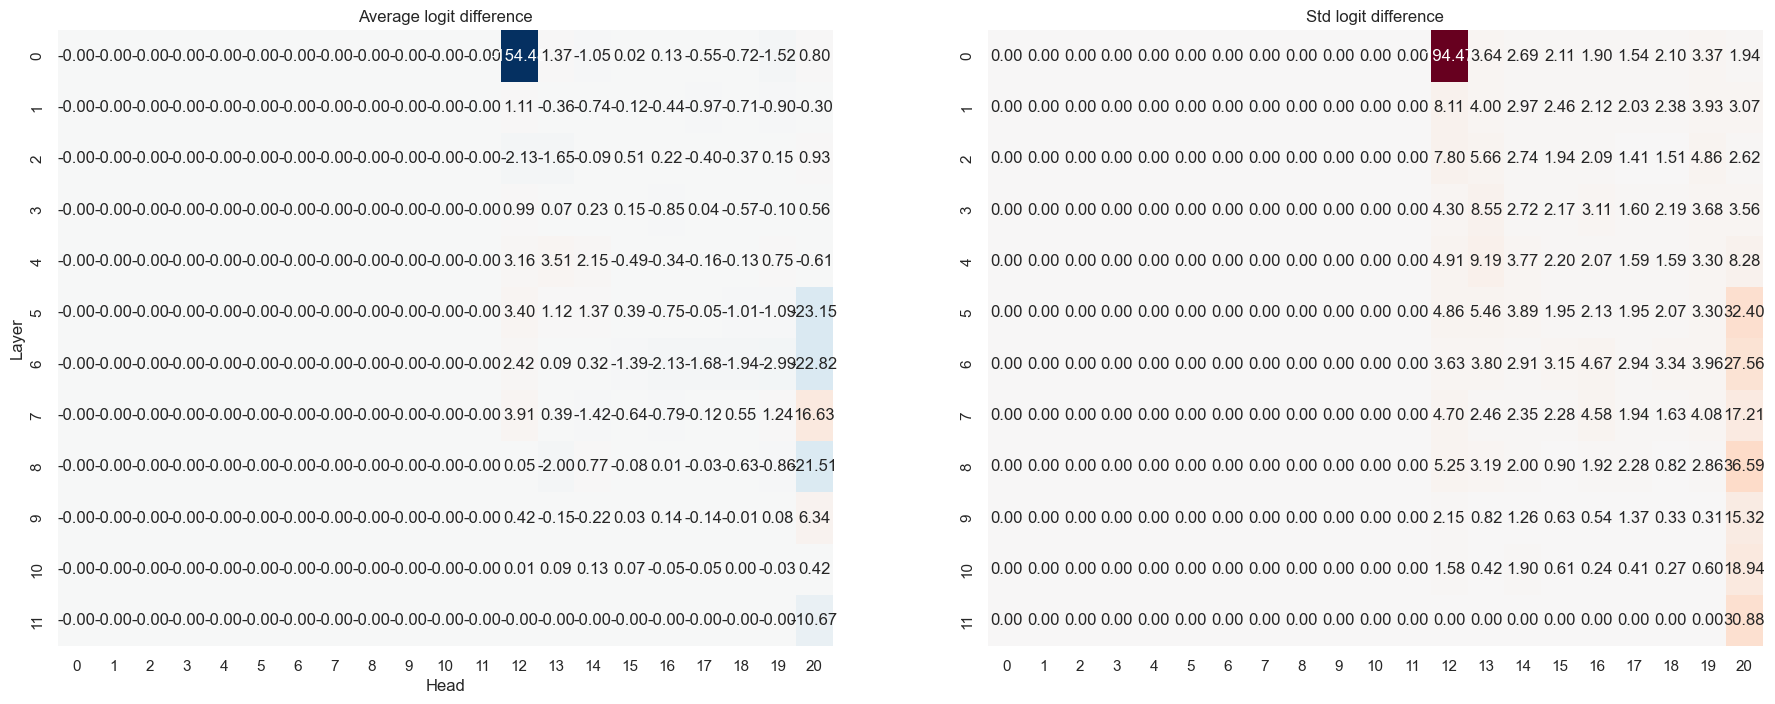

In [25]:
# patch attention head
from functools import partial
from tqdm import tqdm
import einops
from copy import deepcopy


def heads_hook(activation, hook, pos, clean_activation, pos1=None, pos2=None):
    activation[:,pos, :] = clean_activation[:,pos, :]
    return activation


position=21
examples_mem = torch.zeros((model.cfg.n_layers, position, num_batches, batch_size), device="cpu")
examples_cp = torch.zeros((model.cfg.n_layers, position, num_batches, batch_size), device="cpu")


for idx, batch in enumerate(dataloader):
    clean_logit, clean_cache = model.run_with_cache(batch["corrupted_prompts"])


            
    for layer in tqdm(range(model.cfg.n_layers), desc="running model"):
        for pos in range(position):
            hook = [(f"blocks.{layer}.hook_mlp_out",
                            partial(
                                heads_hook,
                                pos=pos,
                                clean_activation=clean_cache[f"blocks.{layer}.hook_mlp_out"],
                                )
                            )]
            
            model.reset_hooks()
            logit = model.run_with_hooks(
                batch["clean_prompts"],
                fwd_hooks=hook,
            )[:,-1,:]
            mem, cp = to_logit_token(logit, batch["target"])
            # norm_mem, norm_cp = normalize_logit_token(mem, cp, baseline="corrupted")
            examples_mem[layer, pos, idx, :] = mem.cpu()
            examples_cp[layer, pos, idx, :] = cp.cpu()
        #remove the hooks for the previous layer

        
examples_mem = einops.rearrange(examples_mem, "l h b s -> l h (b s)")
examples_cp = einops.rearrange(examples_cp, "l h b s -> l h (b s)")
for layer in range(model.cfg.n_layers):
    for pos in range(position):
        norm_mem, norm_cp = normalize_logit_token(examples_mem[layer, pos, :], examples_cp[layer, pos, :], baseline="clean")
        examples_mem[layer, pos, :] = norm_mem
        examples_cp[layer, pos, :] = norm_cp
result_cp = examples_cp.mean(dim=-1)
result_cp_std = examples_cp.std(dim=-1)
result_mem = examples_mem.mean(dim=-1)
result_mem_std = examples_mem.std(dim=-1)


# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result_cp.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=1.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_cp_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result_mem.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=1.0,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_mem_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    cmap="RdBu_r",
)

In [26]:
model.to_str_tokens(batch["corrupted_prompts"][28])

['<|endoftext|>',
 'Red',
 'ef',
 'ine',
 ':',
 ' Finnish',
 ' Student',
 ' Health',
 ' Service',
 ' is',
 ' headquartered',
 ' in',
 ' Tehran',
 '.',
 ' Finnish',
 ' Student',
 ' Health',
 ' Service',
 ' is',
 ' headquartered',
 ' in']

In [28]:
result_cp_std[:,12]

tensor([1.1759e+01, 3.6662e+00, 2.7424e+00, 2.3325e+00, 3.3241e+00, 3.3836e+00,
        2.7061e+00, 4.3321e+00, 2.6807e+00, 1.1253e+00, 1.0138e+00, 9.8733e-05])

<Axes: title={'center': 'Std logit difference'}>

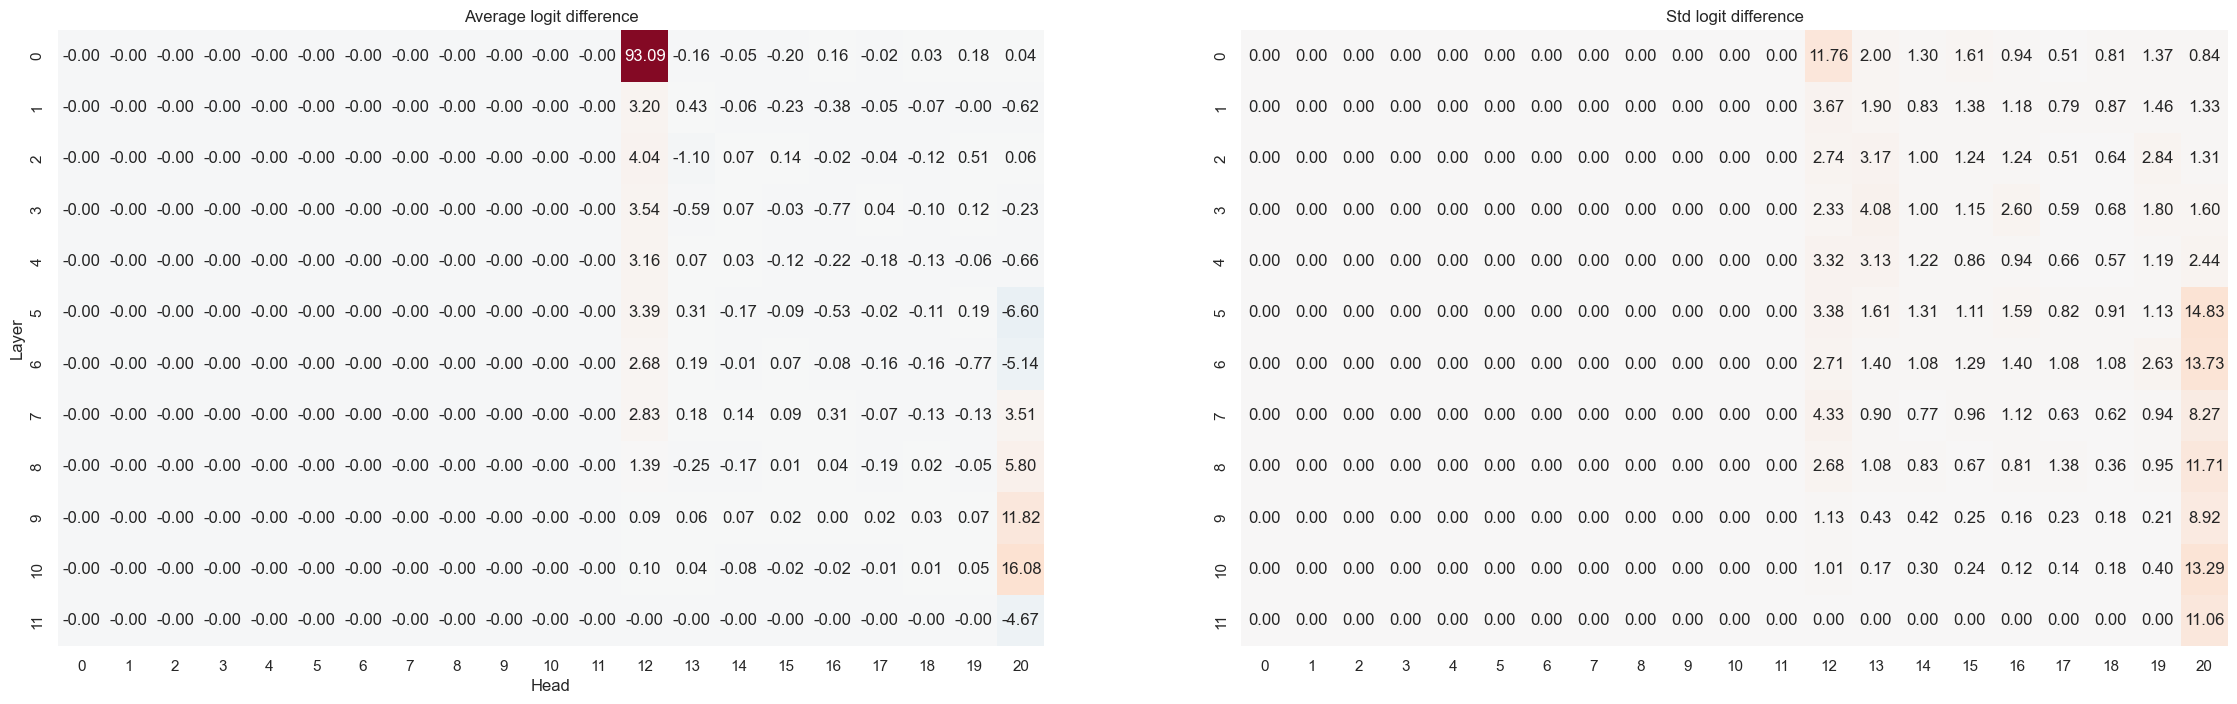

In [29]:

sns.set()
sns.set_style("whitegrid", {"axes.grid": False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
# make the center of the heatmap 0 and white color
sns.heatmap(
    result_cp.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[0],
    center=1.0,
    vmax=100,
    vmin=-100,
    cmap="RdBu_r",
)
# label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(
    result_cp_std.detach().cpu().numpy(),
    annot=True,
    fmt=".2f",
    cbar=False,
    ax=ax[1],
    center=0.0,
    vmax=100,
    vmin=-100,
    cmap="RdBu_r",
)